<a href="https://colab.research.google.com/github/balajisriraj/Analytics-Vidhya-Customer-Segmentation/blob/master/News_Media_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About this Project:

This Project aims to analyze News Articles using NLP techniques, to qunatify about how a particular news is potrayed by differet media houses.
Ultimatly aiming to understand if there are any biases.

#### What is Bias?
- Inclination or prejudice for or against one person or group, especially in a way considered to be unfair. Having said that, it may not be true in all instances, voicing out opinions may be assumed to be biased at quantative level, hence the analysis in this project need not be taken at the face value and requires readers own judgement call.

#### Challenges:
- Its is hard to define what is considered as bias quantitatively as there are multiple qualitative factors involved.
- The pretrained model that we used in this project may also have intrensic model biases and requires fine tuning with proper training data to make sure the possible flaws of the models are not resonated with the outcome of the analysis.

#### Project Flow
- Extract Meta Data from Google News Search results
- Using the URLs in the Meta Data extract News Article Text and other related information using News3k package.
- Preprocess the text information and other features.
- Use pretrained Models to understand the Over all sentiment of the Article and how Sentiment Changes from start to end of the article.
- Use pretrained Models to understand the Over all emotion of the Article and how emotion Changes from start to end of the article.
- Extract Other textual features.
- Do Clustering of the articles.
- Identify the what features contribute to the Cluster formations.
- Use BERTopic identify topics and clusters within.
- Future Work



### Importing Required Packages

In [14]:
#Install all the required Packages
#!pip install -r requirments.txt
!pip install GoogleNews newspaper3k neattext shap transformers sentence_transformers

In [15]:
# Data Processing
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import datetime
import numpy as np
import re
import ast
import time
import string
import neattext as nt
from textblob import TextBlob
import re
from collections import Counter

#Data Extraction
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config

#Analysis
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.corpus  
from nltk.text import Text

#Visulization
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud , STOPWORDS
import plotly.graph_objects as go
import shap

#Models
import sklearn
import lightgbm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelWithLMHead

#Others
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# To prevent SSL Error when using huggingface
import os
os.environ['CURL_CA_BUNDLE'] = ''

### Extract Dataset

#### Configuration

In [16]:
#config will allow us to access the specified url for which we are #not authorized. Sometimes we may get 403 client error while parsing #the link to download the article.
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
# config = Config()
# config.browser_user_agent = user_agent
# config.request_timeout = 15

#Search Configurations
region = 'IN'
start_date =  datetime.date(2023, 1, 24)  #MM/DD/YYYY #datetime.date(2022, 1, 25)'01/24/2023'
end_date =  datetime.date(2023, 3, 31)
no_of_days_from_start_date = end_date - start_date
no_of_days_from_start_date = no_of_days_from_start_date.days
interval_days = 3
periods = round(no_of_days_from_start_date/interval_days)

search_string = 'Adani'
lang='en'
region='IN'
no_of_pages = 3
sleep_time = 20.0

#### Extract Meta Data

In [17]:
def get_meta_data():
    # Contains the final results = news filtered by the criteria 
    # (news that in their description contains the search term).
    # Initial list of results - it will contain a list of dictionaries (dict).
    results = []
    for period in tqdm(range(1,periods+1)):
            #Creating Dynamic Date Ranges
            if period == 1:
                dynamic_end_date = start_date+datetime.timedelta(days=interval_days)
                dynamic_start_date = start_date
            else:
                dynamic_start_date = dynamic_end_date+datetime.timedelta(days=1)
                dynamic_end_date = dynamic_start_date+datetime.timedelta(days=interval_days)
            print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}')
            googlenews=GoogleNews(start=str(dynamic_start_date.strftime("%m/%d/%Y")),end=str(dynamic_end_date.strftime("%m/%d/%Y")),lang=lang, region=region) # I suppose the date is in "MM/dd/yyyy" format...
            googlenews.search(search_string)
            
        # Get first x pages with the results and append those results to the list - you can set any other range according to  your needs: 
            for page in range(1,no_of_pages+1):
                print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}, Page NO : {page}')
                print('Waiting..')
                time.sleep(sleep_time) # Sleep time is set in order not to be blocked for continous searching, please reduce this to extract the data faster
                googlenews.getpage(page) # Consider add an timer for avoid multiple calls and get "HTTP Error 429: Too Many Requests" error.
                results.extend(googlenews.result(sort=True))
    return results


In [18]:
# results = get_meta_data()

In [19]:
def write_meta_data_to_csv(results,search_string=search_string):
    final_results = []
    # Remove duplicates and include to the "final_results" list 
    for item in results: 
                #if (item not in final_results and (search_string in item["desc"])): # only the news that includes in their description the search term:
                    final_results.append(item)
    # Build and show the final dataframe: 
    df=pd.DataFrame(final_results).drop_duplicates()
    df.to_csv(f'./data/raw_data/Meta_data_{search_string}.csv',index=False)

In [20]:
# write_meta_data_to_csv(results,search_string=search_string)

#### Manual URLs

In [21]:
df_manual_meta = pd.read_csv(f'./data/raw_data/Manual_Adani Articles.csv')

In [22]:
#Combining both Extracted Meta URLs & Manual URLs
df = pd.read_csv(f'./data/raw_data/Meta_data_{search_string}.csv')
df = pd.concat([df,df_manual_meta])
df = df.drop_duplicates()

#### Extract Full Article from Meta Data's URLs

In [23]:
# Filter for only certain Media Houses
filter_list = [ 'ABP LIVE','Adani Watch','Ahmedabad Mirror','Bar and Bench','Business Today','CNBCTV18.com',
 'Daily Pioneer','Financial Times','Hindustan Times','IFR','India Today','Indian National Congress',
 'Indtoday','Live Law','Mint','NDTV.com','Onmanorama','OpIndia','Outlook India','PTI','Rediff.com',
 'Republic','Scroll','SwarajyaMag','Telangana Today','Telegraph India','The Business Times','The Economic Times',
 'The Hindu','The Hindu Business Line','The Indian Express','The Morning Context','The New Indian Express',
 'The Wire','ThePrint','Times Now','Times of India','Tribune India','Wire','Zee Business']

In [24]:
df = df[df['media'].isin(filter_list)].drop_duplicates()

In [25]:
def get_full_data(df):
    list = []
    failed_list = []
    for ind in tqdm(df.index):
        dict={}
        url = (df[df.index ==ind]['link']).to_list()[0]
        article = Article(url)
        try:
            article.download()
            article.parse()
            article.nlp()
            dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
            dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
            dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
            dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
            dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
            try:
                dict['Published_Date']=str(article.publish_date)
            except:
                dict['Published_Date']=str(article.publish_date)
            try:
                dict['Title']=article.title
            except:
                dict['Title']='NA'
            try:
                dict['Article']=article.text
            except:
                dict['Article']='NA'
            try:
                dict['Summary']=article.summary
            except:
                dict['Summary']='NA'
            try:
                dict['Authors'] = article.authors
            except:
                dict['Authors'] = 'NA'
            try:
                dict['Keywords'] = article.keywords
            except:
                dict['Keywords'] = 'NA'   
            list.append(dict)
        except:
            failed_list.append(ind)
            dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
            dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
            dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
            dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
            dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
            dict['Published_Date']=str(article.publish_date)
            dict['Title']='NA'
            dict['Article']='NA'
            dict['Summary']='NA'
            dict['Authors'] = 'NA'
            dict['Keywords'] = 'NA'
            list.append(dict)
    return list, failed_list

In [26]:
# list, failed_list = get_full_data(df)

In [27]:
news_df=pd.DataFrame(list)
news_df.to_csv('./data/processed_data/extracted_data_new.csv',index=False)
print('Number Failed Articles : ',len(failed_list)/len(df.index),'%')

ValueError: ignored

### Data Pre - Processing

In [28]:
df_raw = pd.read_csv('./data/processed_data/extracted_data_new.csv')

In [29]:
df_raw = df_raw.drop_duplicates()

In [30]:
df_raw['Meta_Publisher'].nunique()

30

In [31]:
(pd.DataFrame(df_raw['Meta_Publisher'].value_counts())/440).round(2) * 100

Meta_Publisher
Mint                                15.0
The Economic Times                  14.0
Business Today                      13.0
Scroll                               6.0
Times of India                       6.0
Wire                                 5.0
OpIndia                              5.0
The Indian Express                   4.0
The Hindu                            3.0
SwarajyaMag                          3.0
Financial Times                      3.0
The Wire                             3.0
Republic                             2.0
Tribune India                        2.0
The Hindu Business Line              2.0
Hindustan Times                      2.0
Telegraph India                      2.0
India Today                          1.0
ThePrint                             1.0
The New Indian Express               1.0
CNBCTV18.com                         1.0
Daily Pioneer                        1.0
Onmanorama                           1.0
ABP LIVE                             0.0
Times Now                            0.0
Outlook India                        0.0
Telangana Today                      0.0
Indian National Congress             0.0
Zee Business                         0.0
The Business Times                   0.0

In [32]:
fillna_cols = ['Title','Article','Summary','Authors','Keywords']
df_raw[fillna_cols] = df_raw[fillna_cols].fillna('NA') #Filling NA for the cols where we have null values


In [33]:
#Removing rows where we do not have Article text
df_raw = df_raw[df_raw['Article'] != 'NA']
df_raw.reset_index(drop = True,inplace=True)
df_raw['index'] = df_raw.index # Creating an index column
df_raw['Authors_Count'] = df_raw.Authors.transform(ast.literal_eval).str.len() # Getting number of Authors, if there are no Authors info then it would be set to 0.

In [34]:
print('Missing Data on Authors: ',df_raw[df_raw['Authors_Count']== 0].shape[0]/df_raw.shape[0])

Missing Data on Authors:  0.6540404040404041


In [35]:
authors_list = []
#Removing the list format
for authors in df_raw['Authors']:
    temp = authors[1:-1].replace("'", "")
    if temp == '':
        authors_list.append('Not Available')    
    else:
        authors_list.append(temp)
df_raw.Authors = authors_list

Remove noise
- stopwords
- special characters
- punctuations
- hashtags
- @userhandles
- extra spaces
- emails
- special chars
- & many more


In [36]:
#Text Cleaning
failed_indexs = []
for col in ['Meta_title','Meta_desc','Title','Article','Summary']:
    for ind in df_raw.index :
        try:
            sentx = nt.TextFrame(text=df_raw[col][ind])
            text = sentx.remove_hashtags()
            text = text.remove_userhandles()
            text = text.remove_bad_quotes()
            text = text.remove_emails()
            text = text.remove_currency_symbols()
            text = text.remove_dates()
            text = text.remove_phone_numbers()
            text = text.remove_multiple_spaces()
            text = text.remove_html_tags()
            text = text.remove_emojis()
            text = text.remove_emails()
            #text = text.remove_puncts()
            text = text.remove_urls()
            text = text.remove_special_characters()
            #text = text.remove_stopwords() # Stopwords are not removed here since we use Pre-Trained models
            text = str(text)
            text = text.replace("\n", "")
            text = text.replace("’s", "")
            df_raw[col][ind] = text
        except:
            failed_indexs.append(ind)
            pass
    print(f'Cleaning Completed for : {col}')
print('Failed Cases : ',len(failed_indexs))

Cleaning Completed for : Meta_title
Cleaning Completed for : Meta_desc
Cleaning Completed for : Title
Cleaning Completed for : Article
Cleaning Completed for : Summary
Failed Cases :  180


In [37]:
#Grouping similar media houses to same entity
df_raw.loc[df_raw['Meta_Publisher'].isin(['Wire',]),'Meta_Publisher'] = 'The Wire'

In [38]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Using Pre-Trained Models for Sentiment & Emotion Classification

#### Sentiment Prediction - Article

In [39]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [40]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [41]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

In [42]:
def get_sentiment(tokens):
    outputs = model(**tokens)
    probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)

def chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length,window_length):
    proba_list = []
    start = 0
    window_length = window_length

    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]

        # Append [CLS] and [SEP]
        input_id_chunk = [101] + input_id_chunk + [102]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]

        # Convert type list to pytroch tensor
        input_dict = {
            'input_ids' : torch.Tensor([input_id_chunk]).long(),
            'attention_mask' : torch.Tensor([attention_mask_chunk]).int()
        }

        outputs = model(**input_dict)
        probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)
        proba_list.append(probabilities)
        start = end

    return proba_list

def get_mean_from_proba(proba_list,index):
    with torch.no_grad():
        ###
        temp_sentiment = []
        temp_sentiment_score = []
        for list in proba_list:
            with torch.no_grad():
                temp_score = round(list.max().item(),2)
                temp_sentiment_score.append(temp_score)
                temp_senti = torch.argmax(list).item()
                temp_sentiment.append(temp_senti)
            df_raw['sentiment_flow'] [index] = str(temp_sentiment)
            df_raw['sentiment_flow_score'][index] = str(temp_sentiment_score)
        ###
        stacks = torch.stack(proba_list)
        stacks = stacks.resize(stacks.shape[0],stacks.shape[2])
        mean = stacks.mean(dim = 0)
        score = round(mean.max().item(),2)
        mean = torch.argmax(mean).item()
    return mean ,score

In [43]:
Article_Overall_Sentiment = []
Article_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Article'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/11))
    article_sentiment,score = get_mean_from_proba(proba_list,index)
    Article_Overall_Sentiment.append(article_sentiment)
    Article_Overall_Sentiment_score.append(score)

  0%|          | 0/396 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


In [44]:
df_raw['Article_Overall_Sentiment'] = Article_Overall_Sentiment
df_raw['Article_Overall_Sentiment_score'] = Article_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Article_Overall_Sentiment'] = df_raw['Article_Overall_Sentiment'].map(replace_values)

In [45]:
pd.DataFrame(df_raw['Article_Overall_Sentiment'].value_counts()/396).round(2)*100

Article_Overall_Sentiment
Neutral                        71.0
Negative                       15.0
Positive                       14.0

In [46]:
df_temp = pd.DataFrame(df_raw.groupby(['Meta_Publisher','Article_Overall_Sentiment'])['Article_Overall_Sentiment'].count()).rename(columns = {'Article_Overall_Sentiment': 'Sentiment Count'}).reset_index()

In [47]:
df_temp.pivot_table(values = 'Sentiment Count', columns = 'Article_Overall_Sentiment', index = 'Meta_Publisher').fillna(0.0)

Article_Overall_Sentiment  Negative  Neutral  Positive
Meta_Publisher                                        
Business Today                 12.0     29.0      14.0
CNBCTV18.com                    0.0      3.0       2.0
Daily Pioneer                   0.0      3.0       0.0
Financial Times                 1.0     12.0       0.0
Hindustan Times                 0.0      9.0       0.0
India Today                     1.0      4.0       0.0
Mint                            6.0     45.0      15.0
Onmanorama                      0.0      3.0       0.0
OpIndia                         2.0     14.0       1.0
Outlook India                   0.0      2.0       0.0
Republic                        1.0      9.0       1.0
Scroll                         14.0     10.0       3.0
SwarajyaMag                     2.0     10.0       2.0
Telangana Today                 0.0      1.0       0.0
Telegraph India                 0.0      5.0       2.0
The Economic Times              6.0     41.0      11.0
The Hindu                       2.0     12.0       1.0
The Hindu Business Line         4.0      6.0       1.0
The Wire                        3.0     27.0       3.0
ThePrint                        1.0      5.0       0.0
Times Now                       0.0      1.0       0.0
Times of India                  4.0     20.0       1.0
Tribune India                   0.0      8.0       0.0
Zee Business                    0.0      1.0       0.0

In [48]:
df_temp = pd.DataFrame(df_raw.groupby(['Meta_Publisher','Article_Overall_Sentiment'])['Article_Overall_Sentiment_score'].mean()).rename(columns = {'Article_Overall_Sentiment_score': 'Sentiment Score'}).reset_index()

In [49]:
df_temp.pivot_table(values = 'Sentiment Score', columns = 'Article_Overall_Sentiment', index = 'Meta_Publisher').fillna(0.0).round(2)

Article_Overall_Sentiment  Negative  Neutral  Positive
Meta_Publisher                                        
Business Today                 0.60     0.63      0.60
CNBCTV18.com                   0.00     0.67      0.56
Daily Pioneer                  0.00     0.70      0.00
Financial Times                0.53     0.91      0.00
Hindustan Times                0.00     0.82      0.00
India Today                    0.59     0.86      0.00
Mint                           0.64     0.67      0.60
Onmanorama                     0.00     0.90      0.00
OpIndia                        0.66     0.61      0.51
Outlook India                  0.00     0.96      0.00
Republic                       0.44     0.73      0.41
Scroll                         0.62     0.55      0.41
SwarajyaMag                    0.44     0.79      0.49
Telangana Today                0.00     0.69      0.00
Telegraph India                0.00     0.73      0.55
The Economic Times             0.50     0.72      0.50
The Hindu                      0.54     0.72      0.46
The Hindu Business Line        0.60     0.74      0.41
The Wire                       0.51     0.73      0.42
ThePrint                       0.42     0.81      0.00
Times Now                      0.00     0.84      0.00
Times of India                 0.56     0.79      0.64
Tribune India                  0.00     0.80      0.00
Zee Business                   0.00     0.91      0.00

In [50]:
df_temp = pd.DataFrame(df_raw['sentiment_flow'].str.split().values.tolist(),columns=
             ['Article_sentiment_flow_1',
              'Article_sentiment_flow_2',
              'Article_sentiment_flow_3',
              'Article_sentiment_flow_4',
              'Article_sentiment_flow_5',
              'Article_sentiment_flow_6',
              'Article_sentiment_flow_7',
              'Article_sentiment_flow_8',
              'Article_sentiment_flow_9',
              'Article_sentiment_flow_10',
              'Article_sentiment_flow_11',
              'Article_sentiment_flow_12',
              'Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15',
             ])
df_temp.drop(['Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [51]:
df_temp = pd.DataFrame(df_raw['sentiment_flow_score'].str.split().values.tolist(),columns=
             ['Article_sentiment_flowscore_1',
              'Article_sentiment_flowscore_2',
              'Article_sentiment_flowscore_3',
              'Article_sentiment_flowscore_4',
              'Article_sentiment_flowscore_5',
              'Article_sentiment_flowscore_6',
              'Article_sentiment_flowscore_7',
              'Article_sentiment_flowscore_8',
              'Article_sentiment_flowscore_9',
              'Article_sentiment_flowscore_10',
              'Article_sentiment_flowscore_11',
              'Article_sentiment_flowscore_12',
              'Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15',
             ])
df_temp.drop(['Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow_score'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [52]:
replace_values = {'0': "Negative",
                    '1': "Neutral",
                    '2': "Positive"}
replace_cols = ['Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12']
for col in replace_cols:
    df_raw[col] = df_raw[col].map(replace_values)

In [53]:
df_temp = df_raw[['Meta_Publisher','Article_sentiment_flow_1',
       'Article_sentiment_flow_12']]

In [54]:
df_temp.sort_values('Meta_Publisher')

Meta_Publisher Article_sentiment_flow_1  \
197           Business Today                 Negative   
126           Business Today                 Positive   
124           Business Today                 Positive   
294           Business Today                 Negative   
298           Business Today                 Negative   
119           Business Today                  Neutral   
117           Business Today                  Neutral   
113           Business Today                 Negative   
112           Business Today                  Neutral   
109           Business Today                 Positive   
127           Business Today                 Positive   
104           Business Today                  Neutral   
90            Business Today                 Negative   
86            Business Today                 Negative   
85            Business Today                 Negative   
80            Business Today                  Neutral   
334           Business Today                 Negative   
75            Business Today                 Positive   
67            Business Today                 Negative   
57            Business Today                 Negative   
56            Business Today                  Neutral   
98            Business Today                 Positive   
128           Business Today                 Positive   
142           Business Today                  Neutral   
275           Business Today                 Negative   
217           Business Today                 Positive   
200           Business Today                 Positive   
196           Business Today                 Positive   
193           Business Today                 Negative   
224           Business Today                  Neutral   
226           Business Today                  Neutral   
233           Business Today                  Neutral   
181           Business Today                 Negative   
180           Business Today                  Neutral   
244           Business Today                 Positive   
245           Business Today                  Neutral   
171           Business Today                  Neutral   
250           Business Today                 Positive   
167           Business Today                  Neutral   
254           Business Today                 Positive   
162           Business Today                 Negative   
266           Business Today                 Positive   
151           Business Today                  Neutral   
147           Business Today                  Neutral   
145           Business Today                  Neutral   
274           Business Today                 Negative   
55            Business Today                 Positive   
53            Business Today                  Neutral   
215           Business Today                 Negative   
41            Business Today                 Negative   
43            Business Today                  Neutral   
30            Business Today                  Neutral   
28            Business Today                 Negative   
39            Business Today                 Negative   
44            Business Today                 Positive   
287             CNBCTV18.com                 Positive   
133             CNBCTV18.com                  Neutral   
158             CNBCTV18.com                  Neutral   
247             CNBCTV18.com                 Positive   
188             CNBCTV18.com                 Positive   
295            Daily Pioneer                 Negative   
304            Daily Pioneer                  Neutral   
291            Daily Pioneer                 Negative   
22           Financial Times                  Neutral   
21           Financial Times                  Neutral   
299          Financial Times                  Neutral   
114          Financial Times                  Neutral   
37           Financial Times                  Neutral   
206          Financial Times                  Neutral   
139          Financial T

In [55]:
df_temp = df_temp.groupby(['Meta_Publisher','Article_sentiment_flow_1',
       'Article_sentiment_flow_12'])['Article_sentiment_flow_1',
       'Article_sentiment_flow_12'].count().rename(columns = {'Article_sentiment_flow_1':'Start of the Article Count','Article_sentiment_flow_12':'End of the Article Count'}).reset_index()

In [56]:
df_temp = df_temp.rename(columns = {'Article_sentiment_flow_1': 'Start of the Article sentiment','Article_sentiment_flow_12':'End of the Article sentiment'})

In [57]:
df_temp.pivot_table(values = ['Start of the Article Count','End of the Article Count'], columns = ['Start of the Article sentiment'],index = ['Meta_Publisher']).fillna(0.0).round(2)#.reset_index(drop = True)

End of the Article Count                   \
Start of the Article sentiment                 Negative Neutral Positive   
Meta_Publisher                                                             
Business Today                                     5.67    9.50      7.0   
CNBCTV18.com                                       0.00    2.00      3.0   
Daily Pioneer                                      2.00    0.00      0.0   
Financial Times                                    1.00   12.00      0.0   
Hindustan Times                                    1.00    7.00      1.0   
India Today                                        2.00    3.00      0.0   
Mint                                               3.67   17.00      7.5   
Onmanorama                                         2.00    1.00      0.0   
OpIndia                                            5.00    3.67      0.0   
Outlook India                                      0.00    2.00      0.0   
Republic                                           1.00    4.00      0.0   
Scroll                                             5.67    2.00      2.0   
SwarajyaMag                                        3.00    6.00      2.0   
Telangana Today                                    0.00    0.00      1.0   
Telegraph India                                    1.50    2.00      0.0   
The Economic Times                                 9.00   15.50      8.0   
The Hindu                                          3.50    3.00      1.0   
The Hindu Business Line                            6.00    3.00      1.0   
The Wire                                           7.00    9.50      2.0   
ThePrint                                           0.00    4.00      0.0   
Times Now                                          0.00    1.00      0.0   
Times of India                                     4.00   14.00      0.0   
Tribune India                                      2.00    6.00      0.0   

                               Start of the Article Count                   
Start of the Article sentiment                   Negative Neutral Positive  
Meta_Publisher                                                              
Business Today                                       5.67    9.50      7.0  
CNBCTV18.com                                         0.00    2.00      3.0  
Daily Pioneer                                        2.00    0.00      0.0  
Financial Times                                      1.00   12.00      0.0  
Hindustan Times                                      1.00    7.00      1.0  
India Today                                          2.00    3.00      0.0  
Mint                                                 3.67   17.00      7.5  
Onmanorama                                           2.00    1.00      0.0  
OpIndia                                              5.00    3.67      0.0  
Outlook India                                        0.00    2.00      0.0  
Republic                                             1.00    4.00      0.0  
Scroll                                               5.67    2.00      2.0  
SwarajyaMag                                          3.00    6.00      2.0  
Telangana Today                                      0.00    0.00      1.0  
Telegraph India                                      1.50    2.00      0.0  
The Economic Times                                   9.00   15.50      8.0  
The Hindu                                            3.50    3.00      1.0  
The Hindu Business Line                              6.00    3.00      1.0  
The Wire                                             7.00    9.50      2.0  
ThePrint                                             0.00    4.00      0.0  
Times Now                                            0.00    1.00      0.0  
Times of India                                       4.00   14.00      0.0  
Tribune India                                        2.00    6.00      0.0

#### Sentiment Prediction - Title

In [58]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [59]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

#### Sentiment Prediction - Summary

In [60]:
Title_Overall_Sentiment = []
Tile_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Title'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/1))
    Title_sentiment,score = get_mean_from_proba(proba_list,index)
    Title_Overall_Sentiment.append(Title_sentiment)
    Tile_Overall_Sentiment_score.append(score)

  0%|          | 0/396 [00:00<?, ?it/s]

In [61]:
df_raw['Title_Overall_Sentiment'] = Title_Overall_Sentiment
df_raw['Title_Overall_Sentiment_score'] = Tile_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Title_Overall_Sentiment'] = df_raw['Title_Overall_Sentiment'].map(replace_values)

In [62]:
df_raw.drop(['sentiment_flow','sentiment_flow_score'],axis = 1, inplace = True)

In [63]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [64]:
df_raw.columns

Index(['Meta_Publisher', 'Meta_datetime', 'Meta_title', 'Meta_link',
       'Meta_desc', 'Published_Date', 'Title', 'Article', 'Summary', 'Authors',
       'Keywords', 'index', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flo

In [65]:
df_temp = df_raw[['Meta_Publisher','Title_Overall_Sentiment',
       'Title_Overall_Sentiment_score']]

In [66]:
df_temp = df_temp.groupby(['Meta_Publisher','Title_Overall_Sentiment']).agg({'Title_Overall_Sentiment': 'count','Title_Overall_Sentiment_score':'mean' }).rename(columns = {'Title_Overall_Sentiment' : 'Title Sentiment Count', 'Title_Overall_Sentiment_score': 'Title Sentiment Mean Score'}).reset_index()

In [67]:
df_temp.pivot_table(columns = 'Title_Overall_Sentiment',index = 'Meta_Publisher',values ='Title Sentiment Mean Score' ).fillna(0.0).round(2)*100

Title_Overall_Sentiment  Negative  Neutral  Positive
Meta_Publisher                                      
Business Today               92.0     99.0      95.0
CNBCTV18.com                  0.0    100.0     100.0
Daily Pioneer                 0.0     88.0       0.0
Financial Times               0.0     97.0       0.0
Hindustan Times             100.0     89.0     100.0
India Today                 100.0     72.0      56.0
Mint                         97.0     96.0      98.0
Onmanorama                    0.0     91.0       0.0
OpIndia                      94.0     99.0      88.0
Outlook India                 0.0    100.0       0.0
Republic                     62.0     96.0       0.0
Scroll                       94.0     92.0      93.0
SwarajyaMag                   0.0     97.0      92.0
Telangana Today               0.0    100.0       0.0
Telegraph India             100.0     98.0     100.0
The Economic Times           85.0     97.0     100.0
The Hindu                    95.0     96.0      81.0
The Hindu Business Line      99.0     88.0     100.0
The Wire                     98.0    100.0      89.0
ThePrint                     99.0     98.0      99.0
Times Now                     0.0     99.0       0.0
Times of India               66.0    100.0      99.0
Tribune India                 0.0     99.0     100.0
Zee Business                  0.0    100.0       0.0

In [68]:
#Analysis part - Refer later
# pd.DataFrame(df_raw['Article_Overall_Sentiment'].value_counts())/df_raw['Article_Overall_Sentiment'].count()
# pd.DataFrame(df_raw.groupby('Article_Overall_Sentiment')['Article_Overall_Sentiment_score'].mean())
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Sentiment']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Sentiment'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)
# df_temp.columns = ['Media' ,'Negative',	'Neutral',	'Positive']
# mxs = df_temp.eq(df_temp.max(axis=1), axis=0)
# # join the column names of the max values of each row into a single string
# df_temp['Dominant'] = mxs.dot(mxs.columns + ', ').str.rstrip(', ')
# df_raw = df_raw.sort_values(['Meta_datetime','Meta_Publisher'],ascending=True).reset_index(drop=True)
# df_raw.reset_index(drop=True,inplace = True)
# df_raw['index'] = df_raw.index
# df_raw.to_csv('./data/processed_data/processed_data1.csv',index=False)

#### Emotion Prediction

In [69]:
#Reading Processed data
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [70]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [71]:
df_raw['emotion_flow']  = np.nan
df_raw['emotion_flow_score'] = np.nan

In [72]:
def chunk_text_to_window_size_and_predict_prob(input_ids,total_length,window_length):
    proba_list = []
    start = 0
    input_ids = input_ids[0]
    window_length = window_length
    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        outputs = model.generate(input_ids=input_id_chunk.unsqueeze(0),
               max_length=2)
        dec = [tokenizer.decode(ids) for ids in outputs]
        label = dec[0]
        proba_list.append(label)
        start = end
    return proba_list

In [73]:
Article_Overall_Emotion = []
Article_Overall_Emotion_flow = []
for index in tqdm(df_raw['index']):
        input_ids = tokenizer.encode(df_raw['Article'][index] + '</s>', return_tensors='pt')
        proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,total_length = len(input_ids[0]),window_length = int(len(input_ids[0])/11))
        #getting max emotion
        overall_emotion = Counter(proba_list)
        overall_emotion = Counter(proba_list)
        overall_emotion = overall_emotion.most_common(1)
        Article_Overall_Emotion.append(overall_emotion)
        Article_Overall_Emotion_flow.append(proba_list)     

  0%|          | 0/396 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1291 > 512). Running this sequence through the model will result in indexing errors


In [74]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion_flow:
    cleaned_emotion = []
    for emotion in list:
        temp_emotion = (emotion[6:])
        if temp_emotion in list_of_emotions:
            cleaned_emotion.append(temp_emotion)
        else:
            cleaned_emotion.append(np.NaN)
    final_emotion_list.append(cleaned_emotion)

In [75]:
df_raw['Article_Overall_Emotion_flow'] = final_emotion_list
df_temp = pd.DataFrame(df_raw['Article_Overall_Emotion_flow'].to_list(),columns=[
'Article_emotion_flow_1',
'Article_emotion_flow_2',
'Article_emotion_flow_3',
'Article_emotion_flow_4',
'Article_emotion_flow_5',
'Article_emotion_flow_6',
'Article_emotion_flow_7',
'Article_emotion_flow_8',
'Article_emotion_flow_9',
'Article_emotion_flow_10',
'Article_emotion_flow_11',
'Article_emotion_flow_12',
'Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'
]
)
df_temp.drop(['Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'],axis=1,inplace=True)
df_raw.drop(['Article_Overall_Emotion_flow'],axis=1,inplace = True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [76]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion:
        temp_emotion = (list[0][0][6:])
        if temp_emotion in list_of_emotions:
            final_emotion_list.append(temp_emotion)
        else:
            final_emotion_list.append(np.NaN)

In [77]:
df_raw['Article_Overall_Emotion'] = final_emotion_list

In [78]:
df_raw.drop(['emotion_flow', 'emotion_flow_score'],axis=1,inplace=True)

In [79]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [80]:
df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Emotion'])['Article_Overall_Emotion'].count()

In [81]:
df_temp = pd.DataFrame(df_temp).rename(columns = {'Article_Overall_Emotion':'Article Emotion Count'}).reset_index()

In [82]:
df_temp

Meta_Publisher Article_Overall_Emotion  Article Emotion Count
0            Business Today                   anger                     29
1            Business Today                    fear                      2
2            Business Today                     joy                     22
3            Business Today                 sadness                      2
4              CNBCTV18.com                   anger                      2
5              CNBCTV18.com                     joy                      3
6             Daily Pioneer                   anger                      3
7           Financial Times                   anger                      1
8           Financial Times                     joy                     12
9           Hindustan Times                   anger                      8
10          Hindustan Times                     joy                      1
11              India Today                   anger                      4
12              India Today                    fear                      1
13                     Mint                   anger                     29
14                     Mint                    fear                      5
15                     Mint                     joy                     32
16               Onmanorama                   anger                      3
17                  OpIndia                   anger                     14
18                  OpIndia                    fear                      1
19                  OpIndia                     joy                      2
20            Outlook India                     joy                      2
21                 Republic                   anger                      8
22                 Republic                    fear                      2
23                 Republic                     joy                      1
24                   Scroll                   anger                     23
25                   Scroll                    fear                      2
26                   Scroll                     joy                      2
27              SwarajyaMag                   anger                     10
28              SwarajyaMag                     joy                      4
29          Telangana Today                   anger                      1
30          Telegraph India                   anger                      6
31          Telegraph India                     joy                      1
32       The Economic Times                   anger                     28
33       The Economic Times                    fear                      1
34       The Economic Times                     joy                     28
35       The Economic Times                 sadness                      1
36                The Hindu                   anger                     14
37                The Hindu                    fear                      1
38  The Hindu Business Line                   anger                      5
39  The Hindu Business Line                     joy                      4
40  The Hindu Business Line                 sadness                      2
41                 The Wire                   anger                     29
42                 The Wire                    fear                      1
43                 The Wire                     joy                      2
44                 The Wire                 sadness                      1
45                 ThePrint                   anger                      6
46                Times Now                   anger                      1
47           Times of India                   anger                     14
48           Times of India                    fear                      2
49           Times of India                     joy                      9
50            Tribune India                   anger                      6
51            Tribune India                     joy                      2
52             Zee Business           

In [83]:
df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Emotion', 'Article_Overall_Sentiment'])['Article_Overall_Emotion'].count()

In [84]:
df_temp = pd.DataFrame(df_temp)#.rename(columns = {'Article_Overall_Sentiment':'Emotion-Sentiment Count'}).reset_index()

In [85]:
df_temp = df_temp.rename(columns = {'Article_Overall_Emotion':'Emotion-Sentiment Count'}).reset_index()

In [86]:
df_temp['Sentiment-Emotion'] = df_temp['Article_Overall_Sentiment'].astype('str') + '-' + df_temp['Article_Overall_Emotion'].astype('str')

In [88]:
df_temp.head(5)

Meta_Publisher Article_Overall_Emotion Article_Overall_Sentiment  \
0  Business Today                   anger                  Negative   
1  Business Today                   anger                   Neutral   
2  Business Today                   anger                  Positive   
3  Business Today                    fear                  Negative   
4  Business Today                    fear                   Neutral   

   Emotion-Sentiment Count Sentiment-Emotion  
0                        7    Negative-anger  
1                       20     Neutral-anger  
2                        2    Positive-anger  
3                        1     Negative-fear  
4                        1      Neutral-fear

In [ ]:
# START FROM HERE EMOTION FLOW PIVOT

In [89]:
df_raw.columns

Index(['Meta_Publisher', 'Meta_datetime', 'Meta_title', 'Meta_link',
       'Meta_desc', 'Published_Date', 'Title', 'Article', 'Summary', 'Authors',
       'Keywords', 'index', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flo

In [90]:
df_temp = df_raw[['Meta_Publisher','Article_emotion_flow_1',
       'Article_emotion_flow_2', 'Article_emotion_flow_3',
       'Article_emotion_flow_4', 'Article_emotion_flow_5',
       'Article_emotion_flow_6', 'Article_emotion_flow_7',
       'Article_emotion_flow_8', 'Article_emotion_flow_9',
       'Article_emotion_flow_10', 'Article_emotion_flow_11',
       'Article_emotion_flow_12']]

In [92]:
df_temp.groupby(['Meta_Publisher'])['Article_emotion_flow_1',
       'Article_emotion_flow_2', 'Article_emotion_flow_3',
       'Article_emotion_flow_4', 'Article_emotion_flow_5',
       'Article_emotion_flow_6', 'Article_emotion_flow_7',
       'Article_emotion_flow_8', 'Article_emotion_flow_9',
       'Article_emotion_flow_10', 'Article_emotion_flow_11',
       'Article_emotion_flow_12'].agg(pd.Series.mode).reset_index()

Meta_Publisher Article_emotion_flow_1 Article_emotion_flow_2  \
0            Business Today                  anger                  anger   
1              CNBCTV18.com                    joy                  anger   
2             Daily Pioneer                  anger                  anger   
3           Financial Times                    joy                    joy   
4           Hindustan Times                  anger                  anger   
5               India Today                  anger                  anger   
6                      Mint                  anger                  anger   
7                Onmanorama                  anger                  anger   
8                   OpIndia                  anger                  anger   
9             Outlook India                    joy                     []   
10                 Republic                  anger                  anger   
11                   Scroll                  anger                  anger   
12              SwarajyaMag                  anger                  anger   
13          Telangana Today                  anger                  anger   
14          Telegraph India                  anger                    joy   
15       The Economic Times                  anger                    joy   
16                The Hindu                  anger                  anger   
17  The Hindu Business Line                sadness                  anger   
18                 The Wire                  anger                  anger   
19                 ThePrint                  anger                  anger   
20                Times Now                     []                    joy   
21           Times of India                  anger                  anger   
22            Tribune India                  anger                  anger   
23             Zee Business                   fear                    joy   

   Article_emotion_flow_3 Article_emotion_flow_4 Article_emotion_flow_5  \
0                   anger                    joy                    joy   
1                     joy                    joy                    joy   
2                   anger                  anger                  anger   
3                     joy                    joy                  anger   
4                   anger                  anger                  anger   
5                   anger                  anger           [anger, joy]   
6                   anger                    joy                    joy   
7                   anger                  anger                  anger   
8                   anger                  anger                  anger   
9                   anger                    joy                  anger   
10                  anger                  anger                  anger   
11                  anger                  anger                  anger   
12                    joy                  anger                  anger   
13                  anger                  anger                  anger   
14                  anger                  anger                  anger   
15                  anger                  anger                    joy   
16                  anger                  anger                  anger   
17           [anger, joy]                  anger                  anger   
18                  anger                  anger                  anger   
19                  anger           [anger, joy]                  anger   
20                  anger                  anger                  anger   
21                    joy                  anger                  anger   
22                  anger                  anger                  anger   
23                    joy                    joy                    joy   

   Article_emotion_flow_6 Article_emotion_flow_7 Article_emotion_flow_8  \
0                   anger                    joy                  anger   
1                     joy                    joy             

In [93]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [94]:
# Analysis part -> Refer later
# pd.DataFrame(df_raw['Article_Overall_Emotion'].value_counts())/df_raw['Article_Overall_Emotion'].count()
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Emotion']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Emotion'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)


In [95]:
# Polarity, Subjectivity
# Creating Features
df_raw[['Article_polarity', 'Article_subjectivity']] = df_raw['Article'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_raw[['Title_polarity', 'Tile_subjectivity']] = df_raw['Title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [105]:
import plotly.express as px
fig = px.scatter(df_raw, x="Article_subjectivity", y="Article_polarity", color="Meta_Publisher",
                 size='Article_Overall_Sentiment_score', hover_data=['Article_Overall_Sentiment'],trendline="lowess", trendline_scope="overall",
                 title="Article Subjectivity vs Polority",
                 height=900)
fig.show()

In [106]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Clustering

In [107]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

#### Simplified clustering

In [108]:
req_cols = ['Meta_Publisher', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flowscore_10', 'Article_sentiment_flowscore_11',
       'Article_sentiment_flowscore_12', 'Title_Overall_Sentiment',
       'Title_Overall_Sentiment_score', 'Article_emotion_flow_1',
       'Article_emotion_flow_2', 'Article_emotion_flow_3',
       'Article_emotion_flow_4', 'Article_emotion_flow_5',
       'Article_emotion_flow_6', 'Article_emotion_flow_7',
       'Article_emotion_flow_8', 'Article_emotion_flow_9',
       'Article_emotion_flow_10', 'Article_emotion_flow_11',
       'Article_emotion_flow_12', 'Article_Overall_Emotion',
       'Article_polarity', 'Article_subjectivity', 'Title_polarity',
       'Tile_subjectivity']

In [109]:
df_simple_clust = df_raw[req_cols]

In [110]:
df_simple_clust['Article_sentiment_flow_12'] = df_simple_clust['Article_sentiment_flow_12'].fillna(df_simple_clust['Article_sentiment_flow_11'])
df_simple_clust['Article_sentiment_flowscore_12'] = df_simple_clust['Article_sentiment_flowscore_12'].fillna(df_simple_clust['Article_sentiment_flowscore_12'].mean())
df_simple_clust['Article_emotion_flow_1'] = df_simple_clust['Article_emotion_flow_1'].fillna(df_simple_clust['Article_sentiment_flow_2'])
df_simple_clust['Article_emotion_flow_2'] = df_simple_clust['Article_emotion_flow_2'].fillna(df_simple_clust['Article_sentiment_flow_1'])
df_simple_clust['Article_emotion_flow_3'] = df_simple_clust['Article_emotion_flow_3'].fillna(df_simple_clust['Article_sentiment_flow_2'])
df_simple_clust['Article_emotion_flow_4'] = df_simple_clust['Article_emotion_flow_4'].fillna(df_simple_clust['Article_sentiment_flow_3'])
df_simple_clust['Article_emotion_flow_5'] = df_simple_clust['Article_emotion_flow_5'].fillna(df_simple_clust['Article_sentiment_flow_4'])
df_simple_clust['Article_emotion_flow_6'] = df_simple_clust['Article_emotion_flow_6'].fillna(df_simple_clust['Article_sentiment_flow_5'])
df_simple_clust['Article_emotion_flow_7'] = df_simple_clust['Article_emotion_flow_7'].fillna(df_simple_clust['Article_sentiment_flow_6'])
df_simple_clust['Article_emotion_flow_8'] = df_simple_clust['Article_emotion_flow_8'].fillna(df_simple_clust['Article_sentiment_flow_7'])
df_simple_clust['Article_emotion_flow_9'] = df_simple_clust['Article_emotion_flow_9'].fillna(df_simple_clust['Article_sentiment_flow_8'])
df_simple_clust['Article_emotion_flow_10'] = df_simple_clust['Article_emotion_flow_10'].fillna(df_simple_clust['Article_sentiment_flow_9'])
df_simple_clust['Article_emotion_flow_11'] = df_simple_clust['Article_emotion_flow_11'].fillna(df_simple_clust['Article_sentiment_flow_10'])
df_simple_clust['Article_emotion_flow_12'] = df_simple_clust['Article_emotion_flow_12'].fillna(df_simple_clust['Article_sentiment_flow_11'])

In [111]:
#One-Hot-Encoding
data = pd.get_dummies(df_simple_clust)
#Pre-processing
for c in data.columns:
    pt = sklearn.preprocessing.PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [136]:
#Actual Clustering
kmeans = KMeans(n_clusters=2).fit(data)
kmeans_labels = kmeans.labels_

In [137]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y= list(sse.values())
                                ))
fig.show()

  0%|          | 0/48 [00:00<?, ?it/s]

TypeError: ignored

In [138]:
#Setting the objects to category 
lgbm_data = df_simple_clust.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
#KMeans clusters
clf_km = lightgbm.LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = sklearn.model_selection.cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means clusters is 0.9442591783472624


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


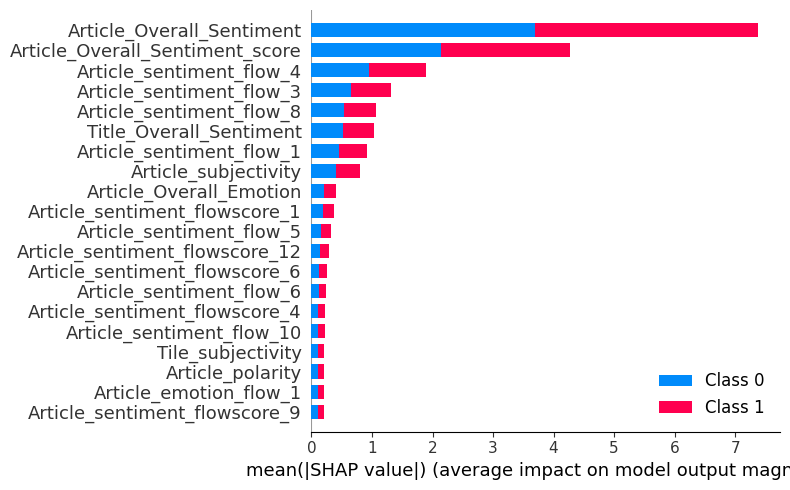

In [139]:
#Fit the model
clf_km.fit(lgbm_data, kmeans_labels)
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(8, 5))

In [140]:
shap.initjs()
shap.force_plot(explainer_km.expected_value[0], shap_values_km[0])

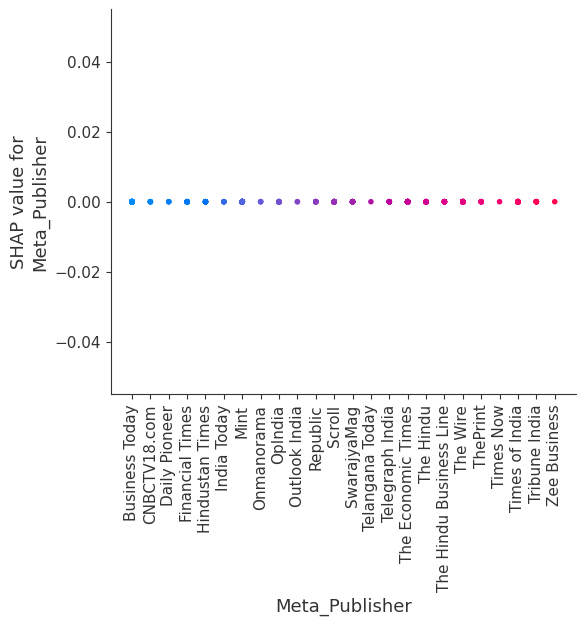

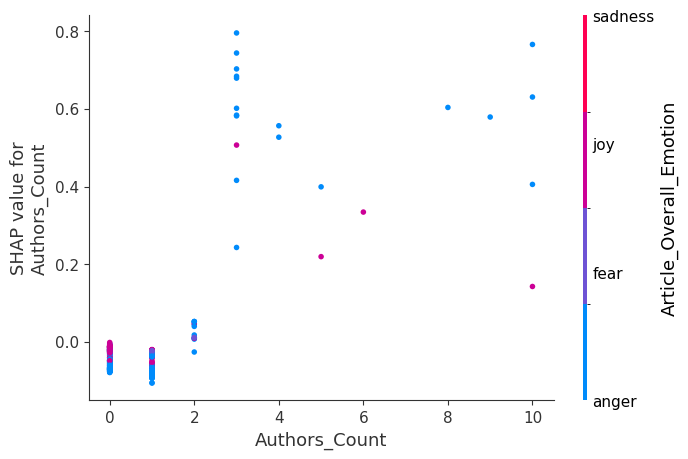

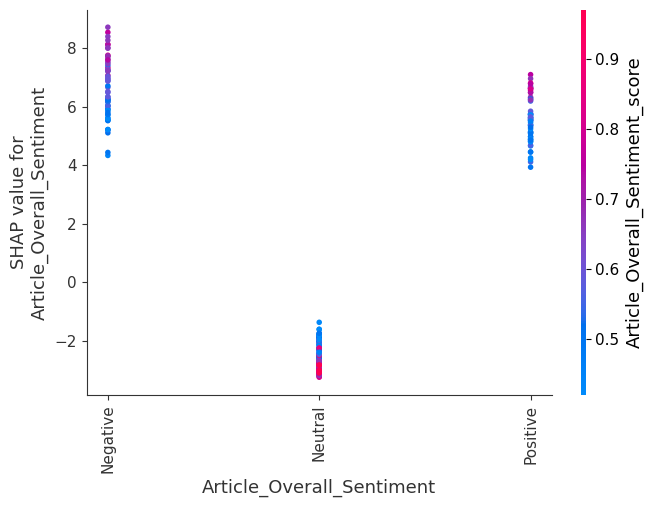

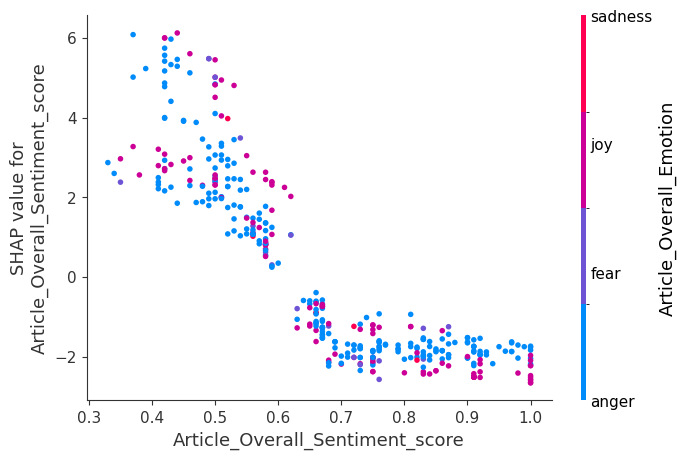

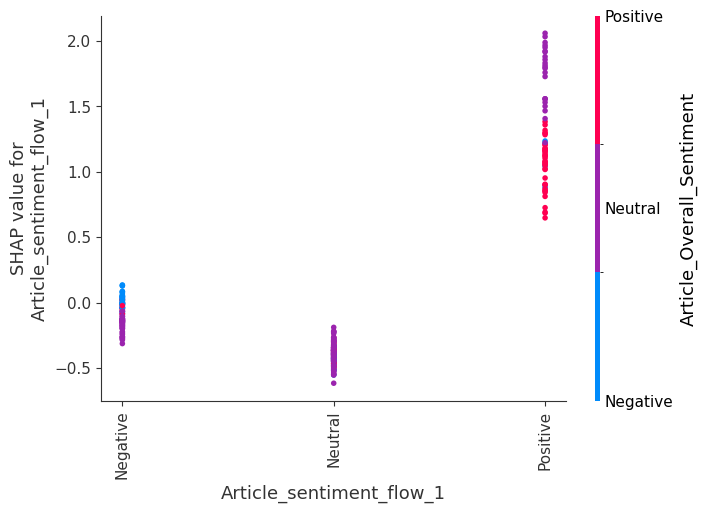

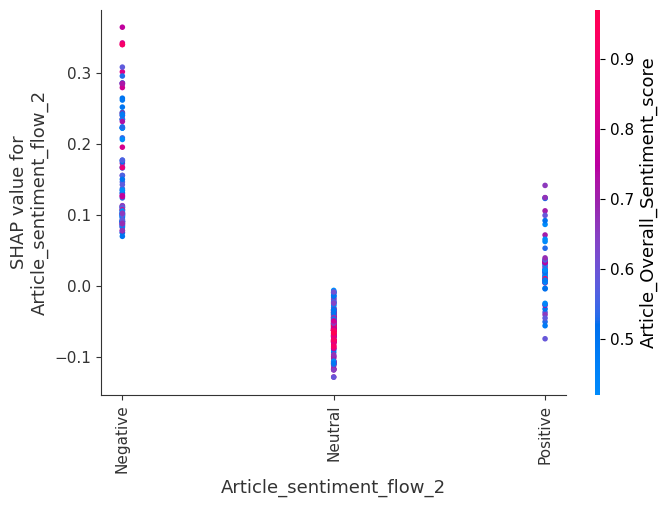

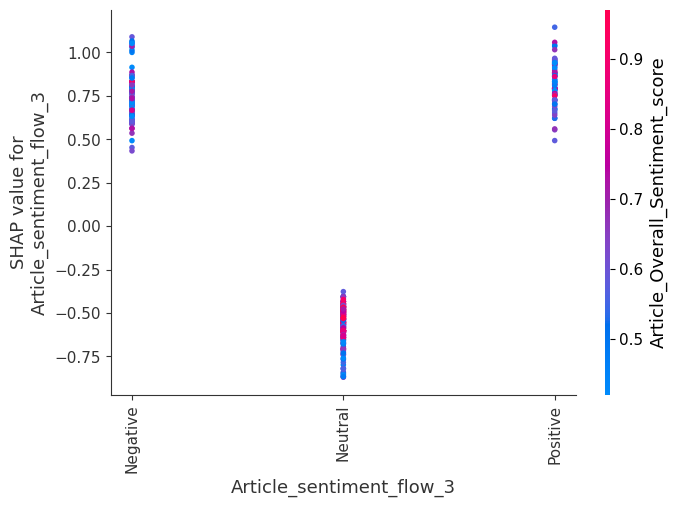

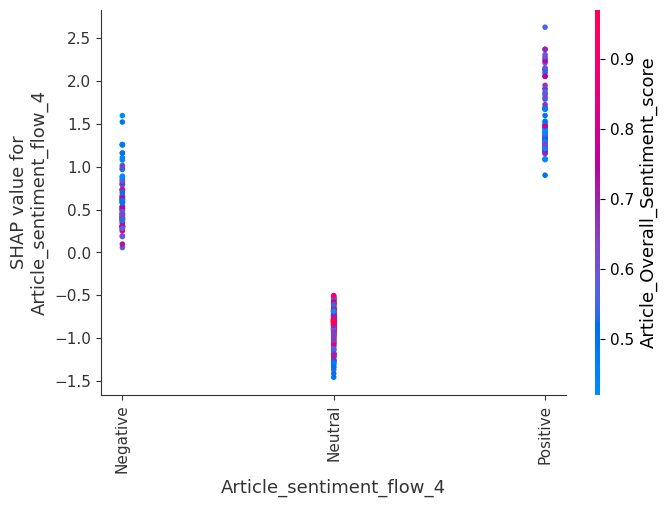

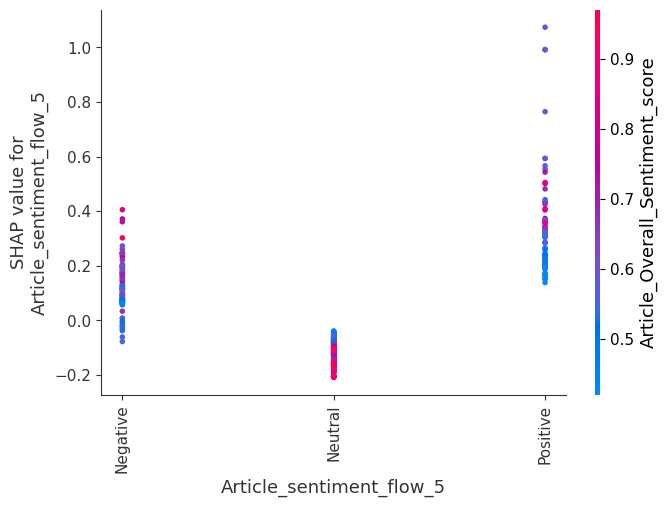

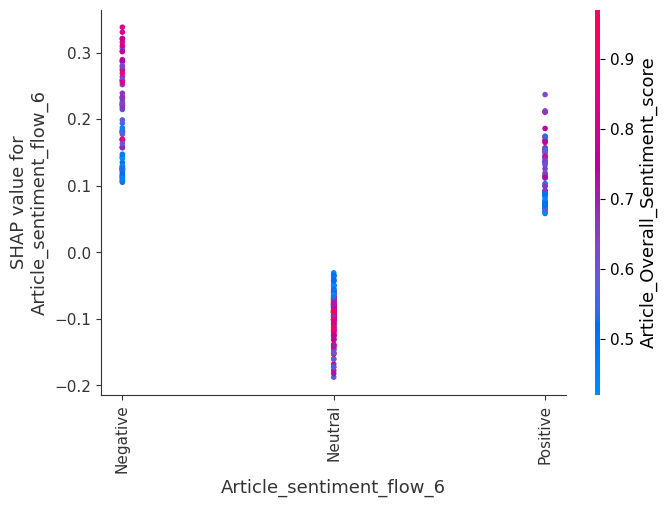

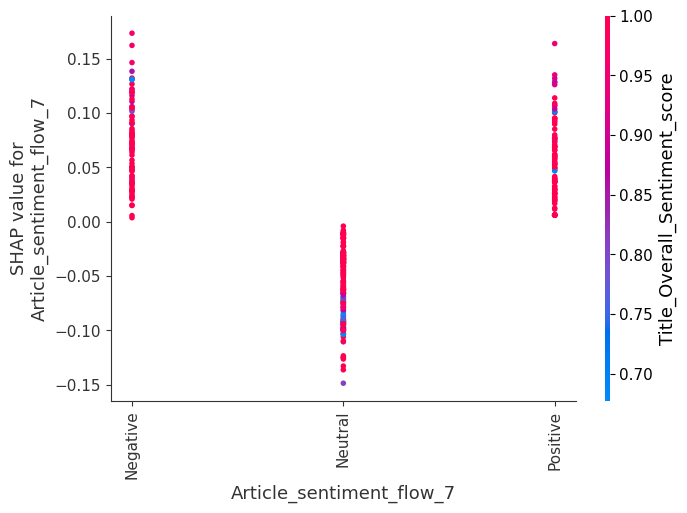

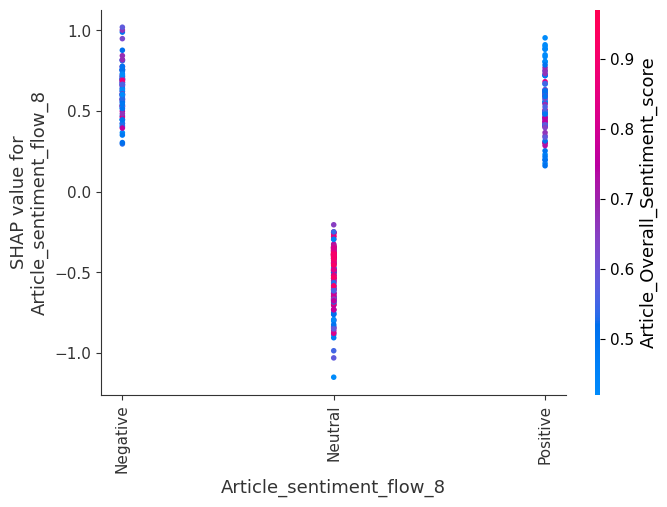

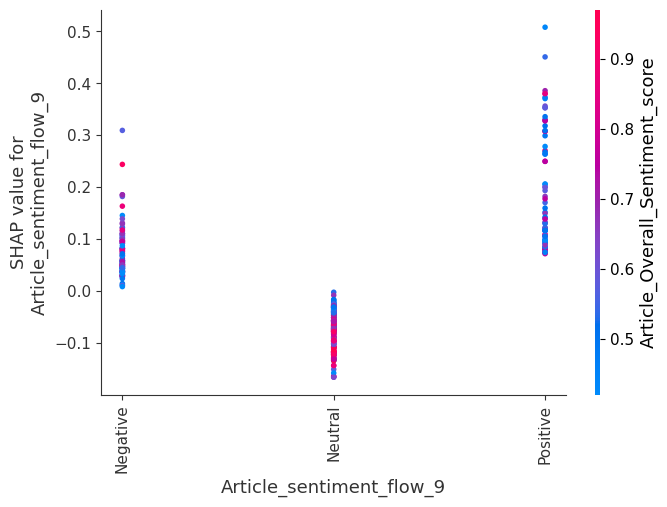

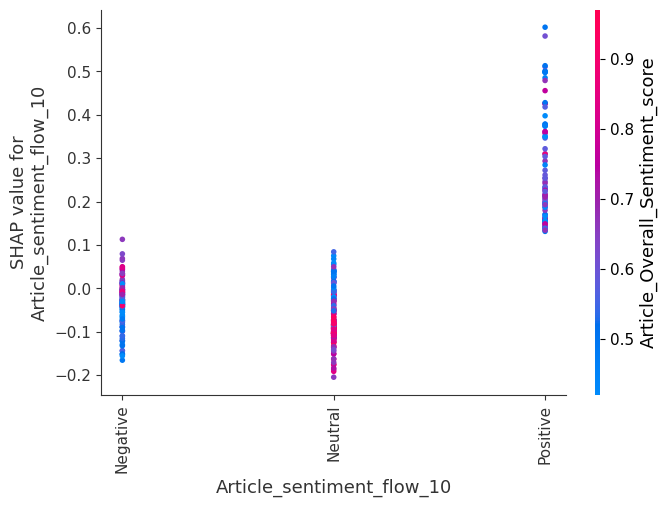

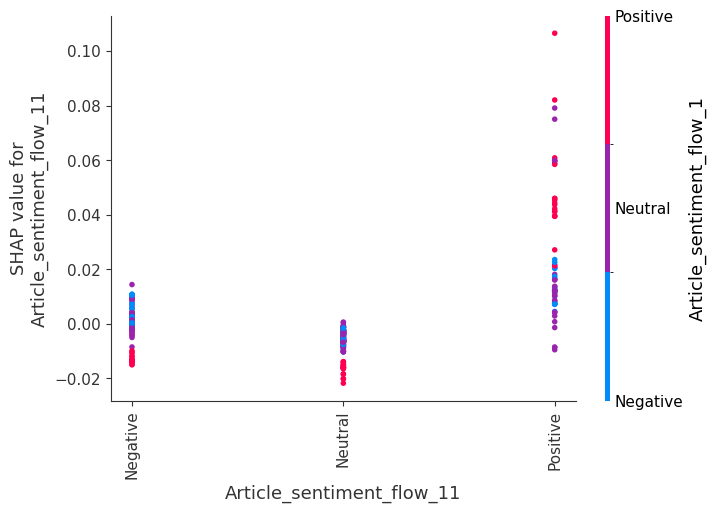

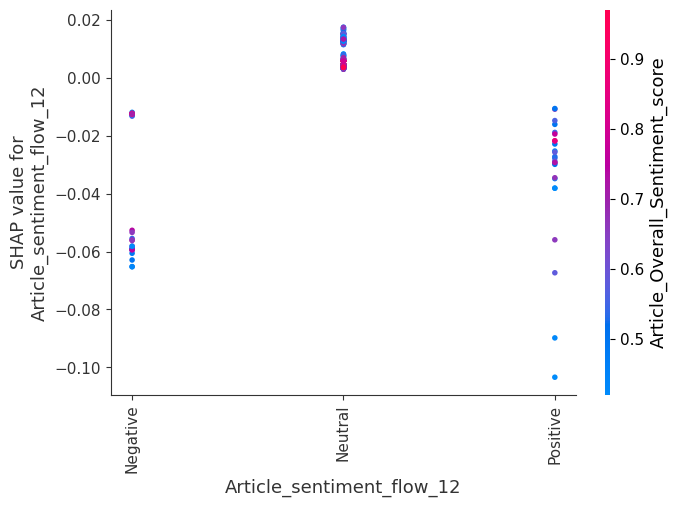

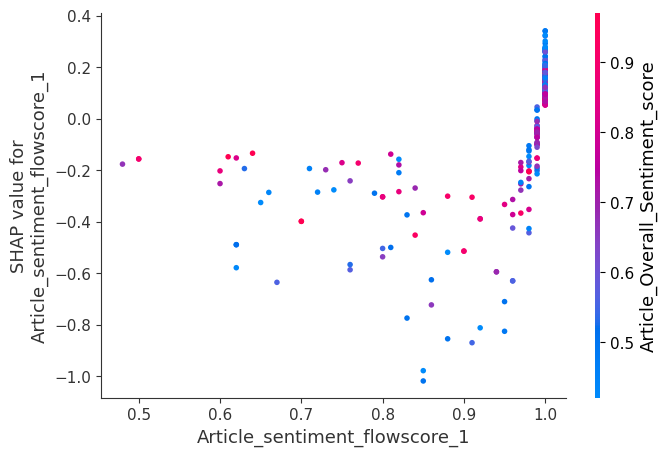

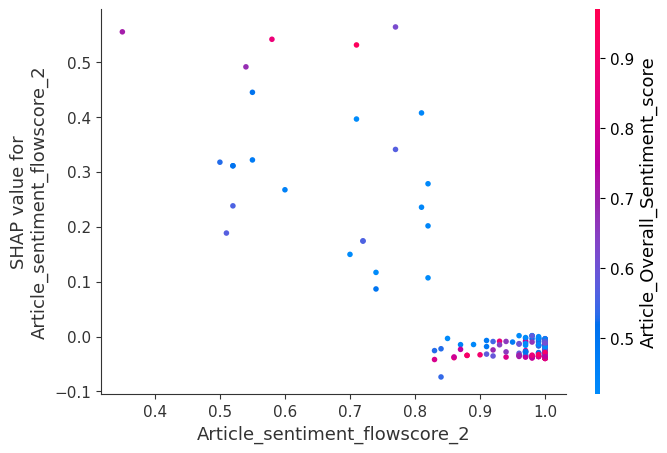

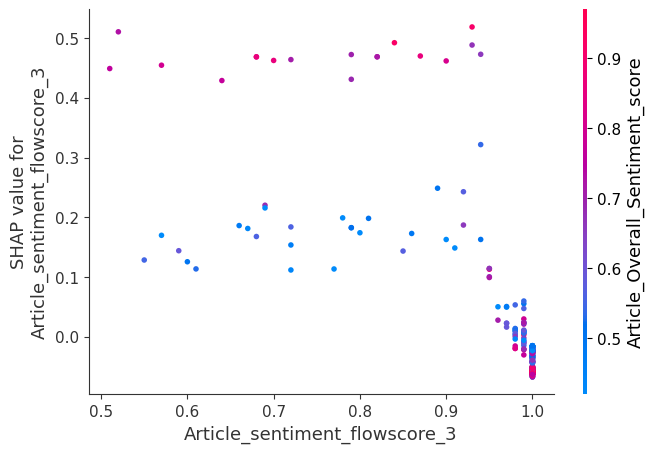

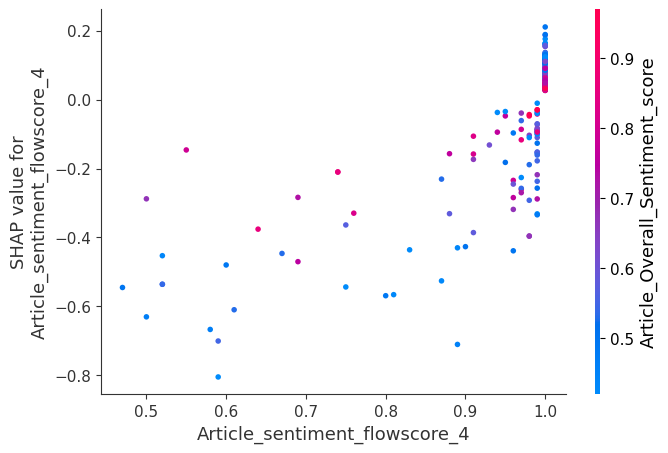

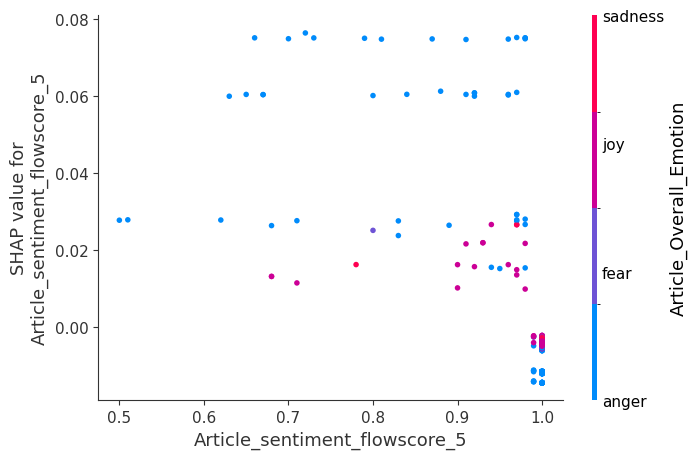

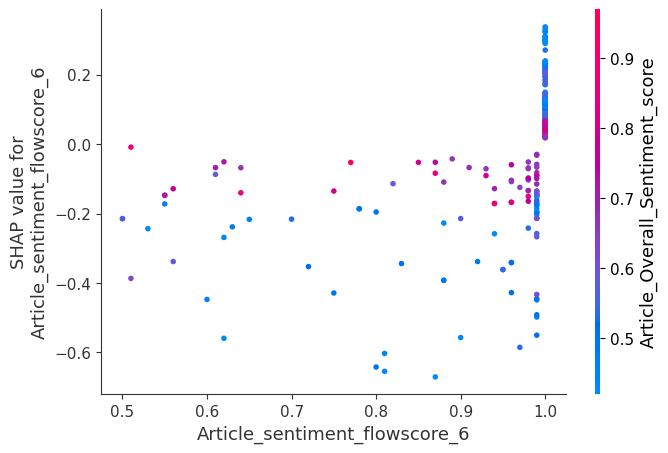

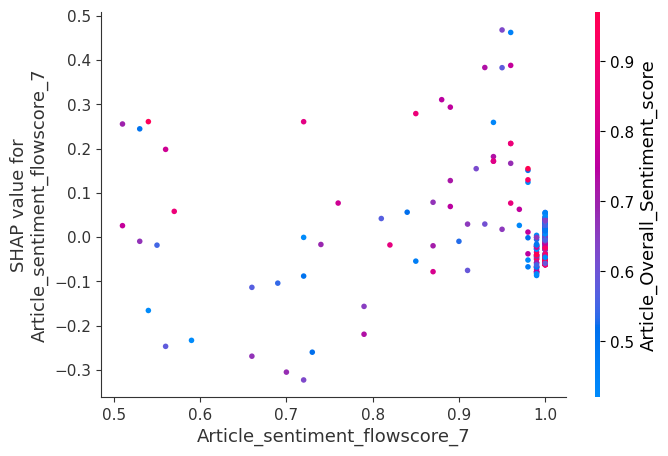

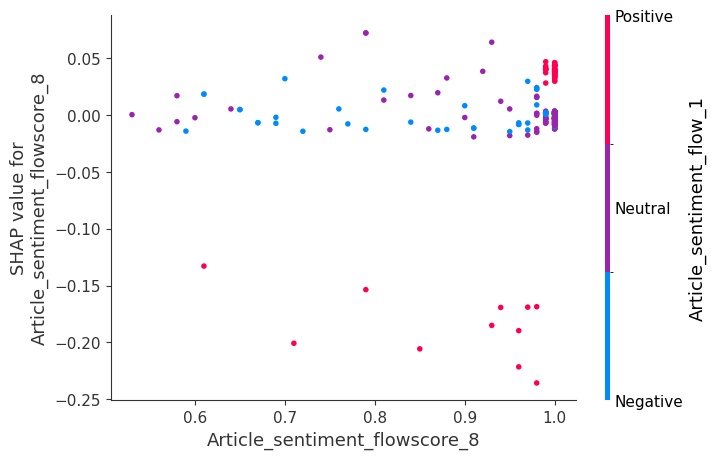

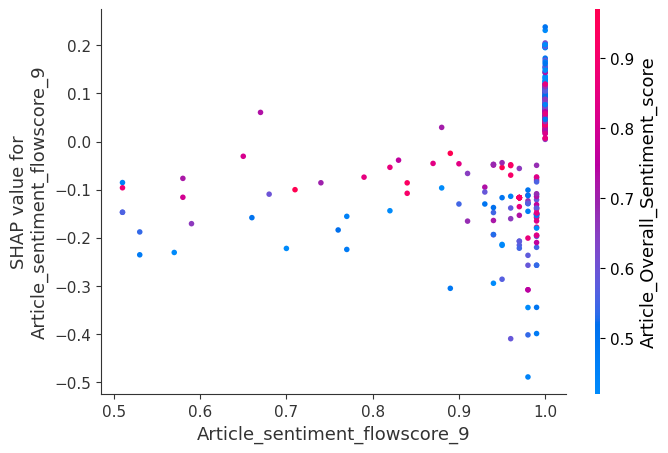

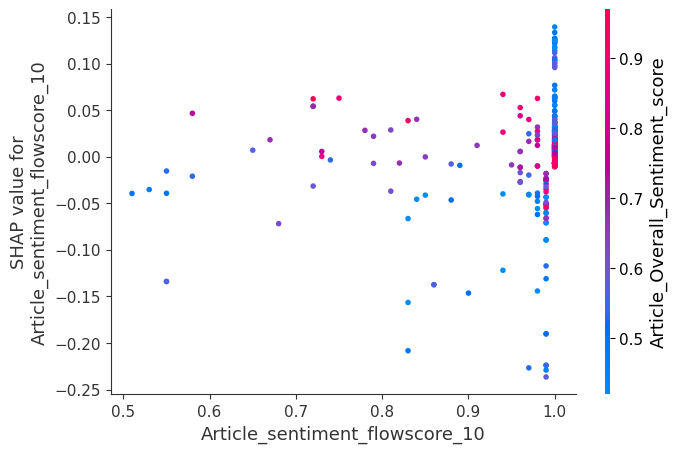

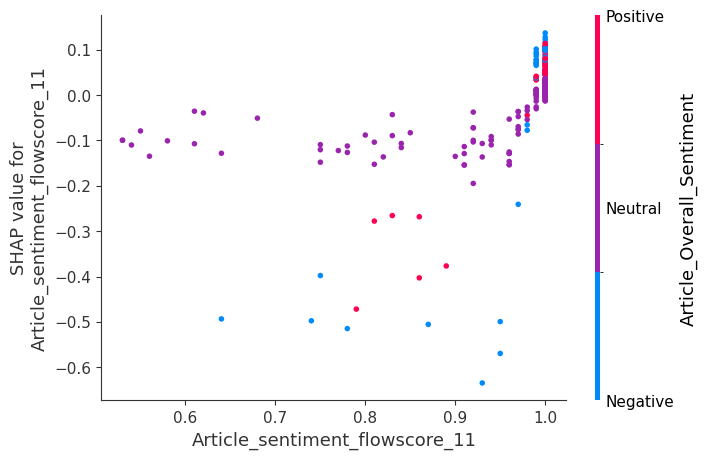

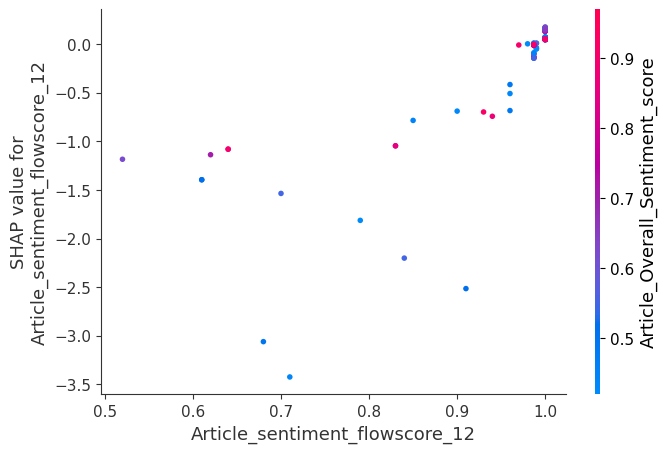

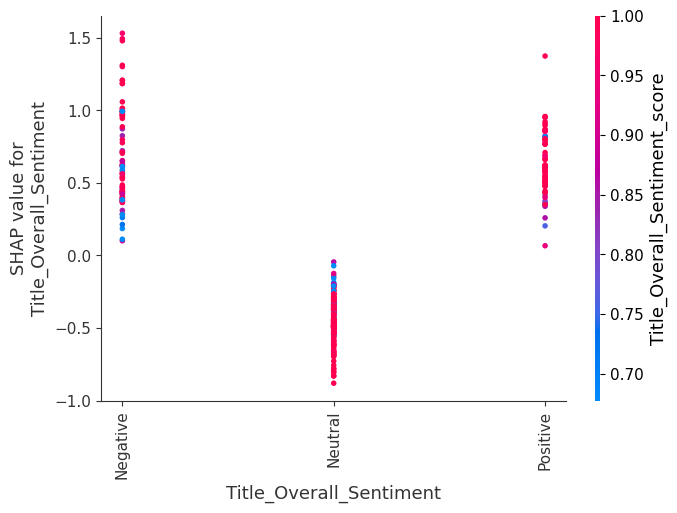

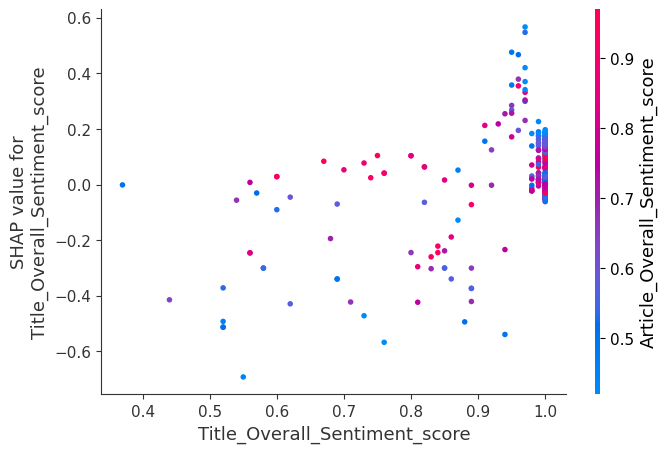

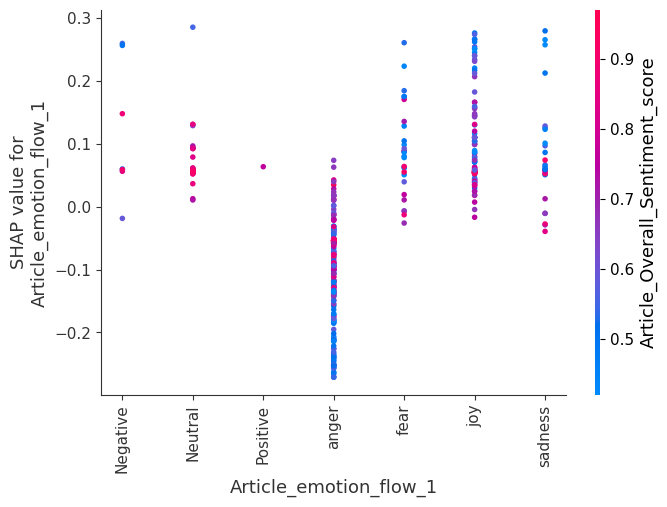

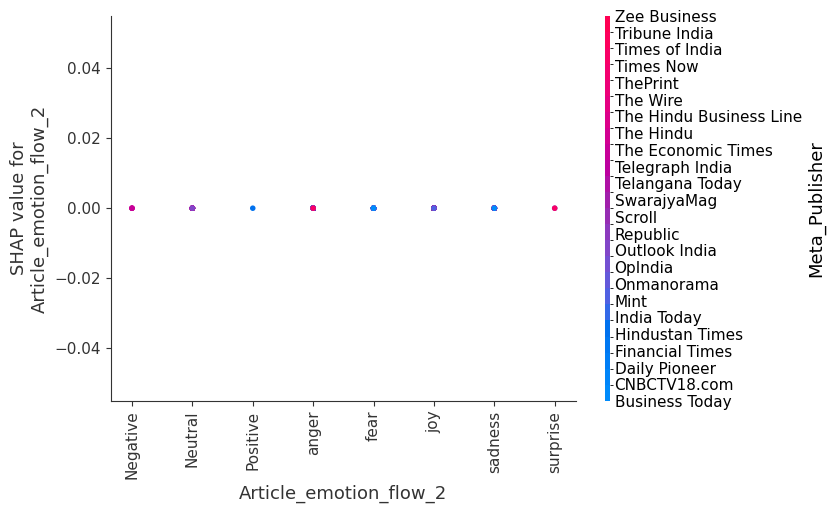

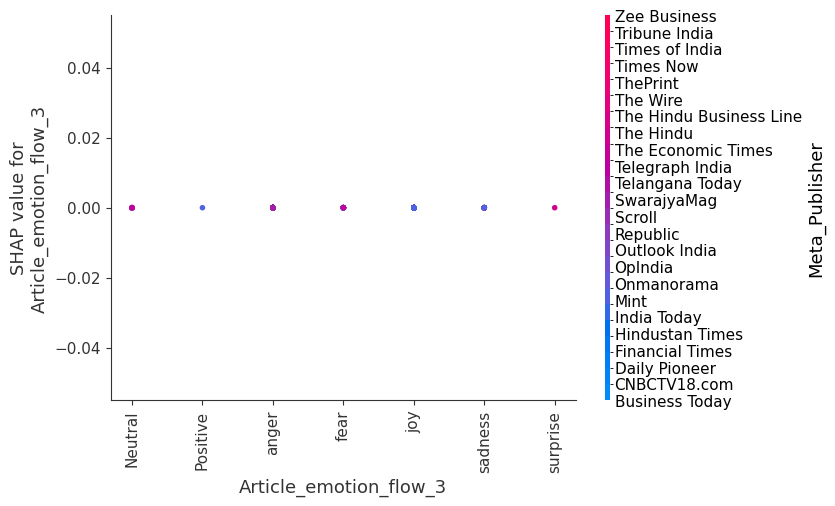

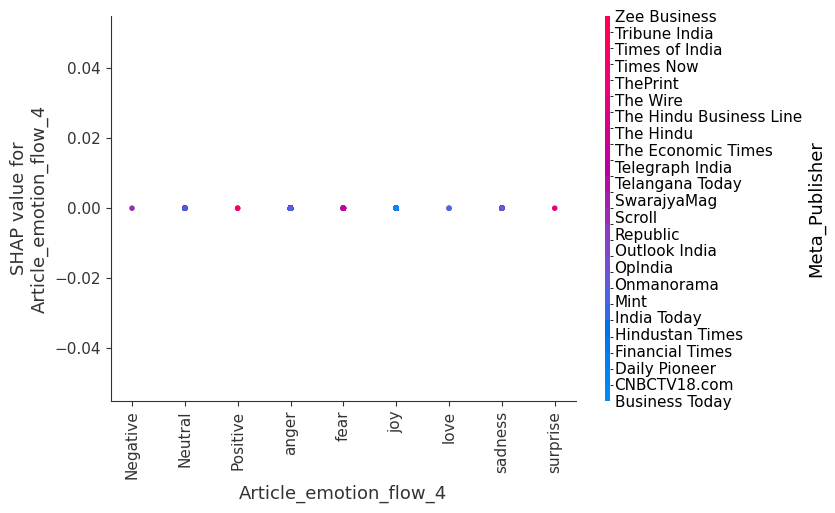

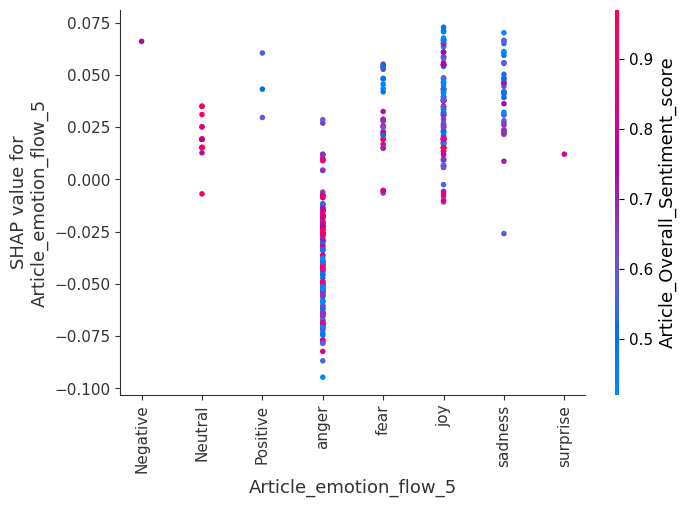

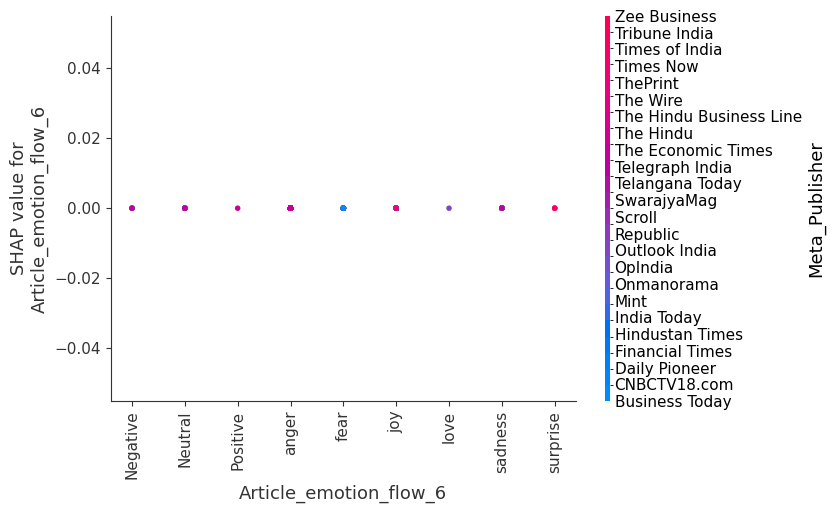

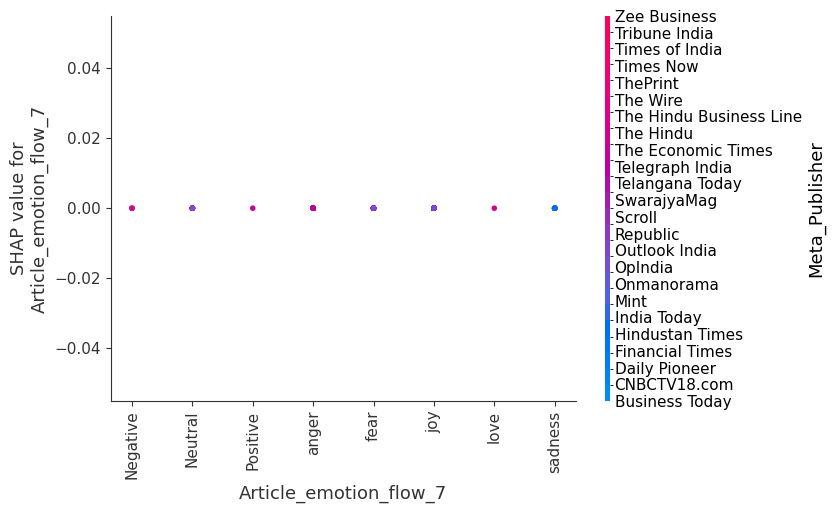

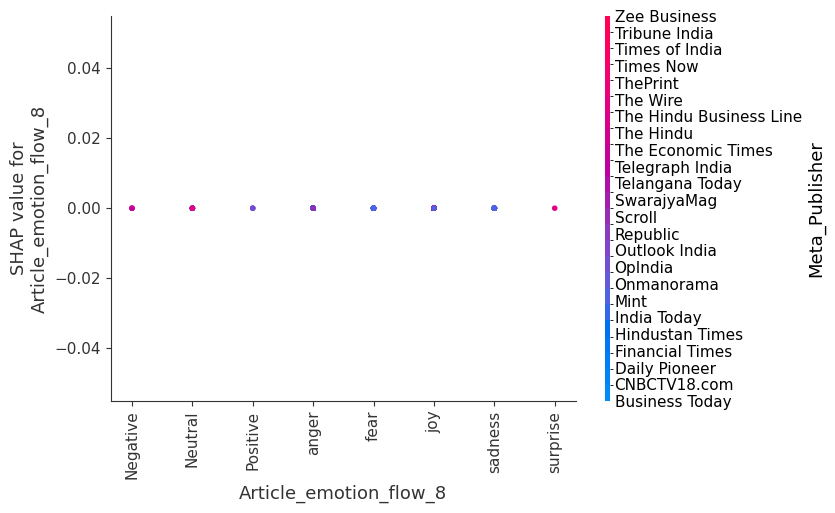

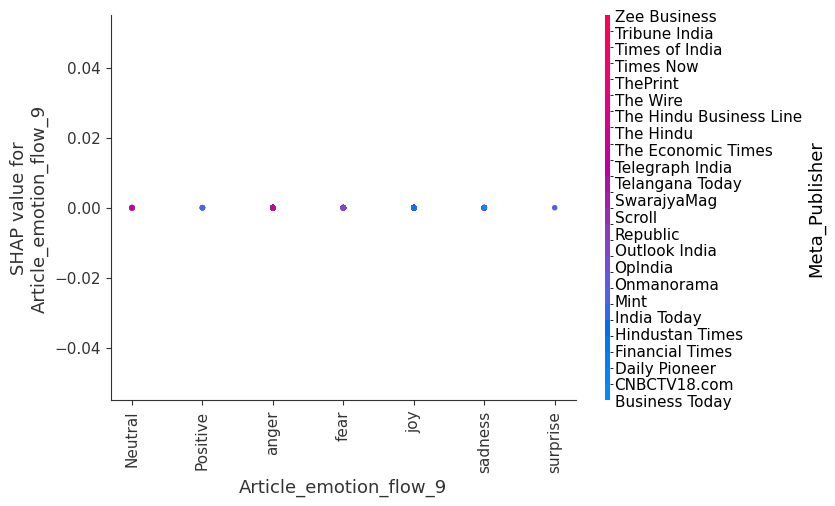

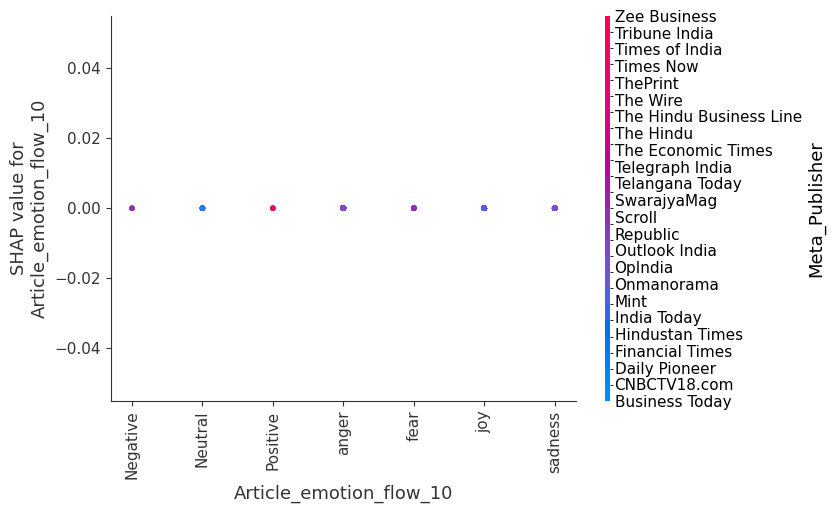

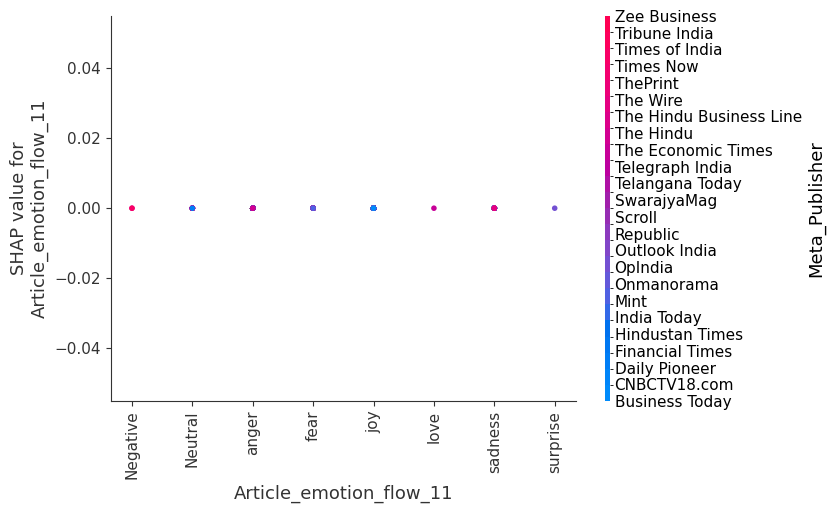

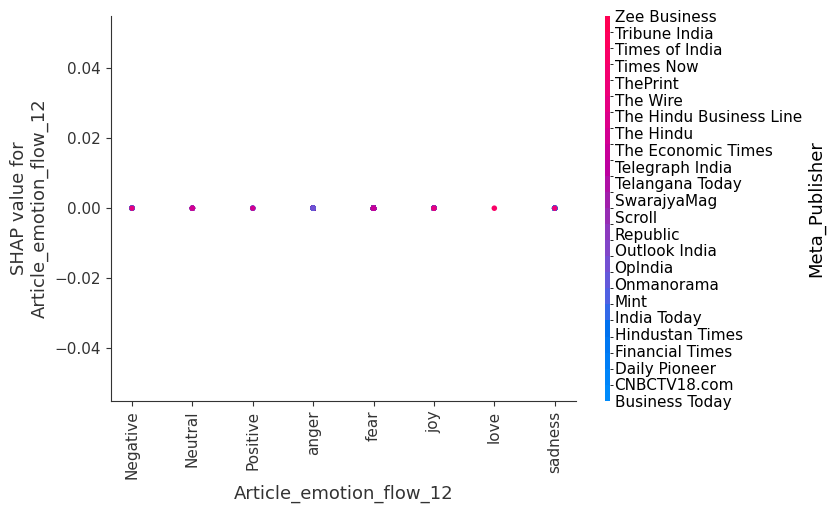

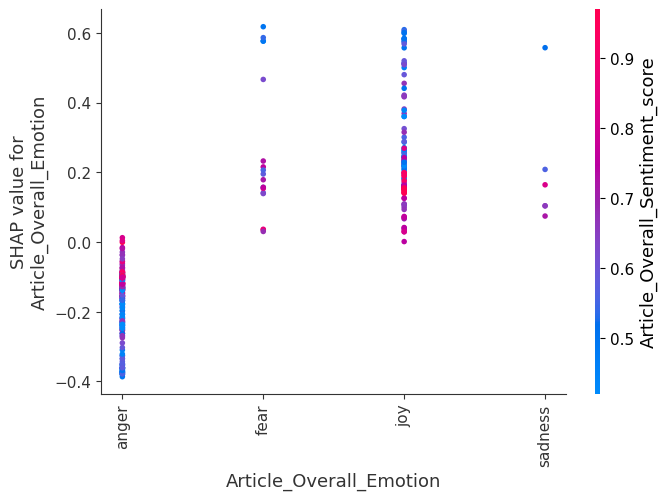

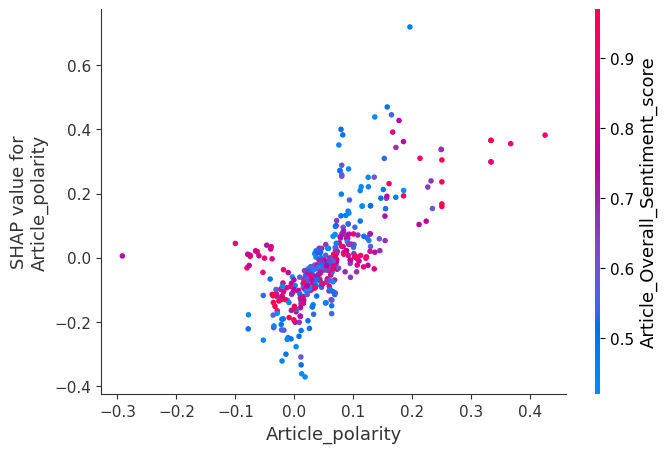

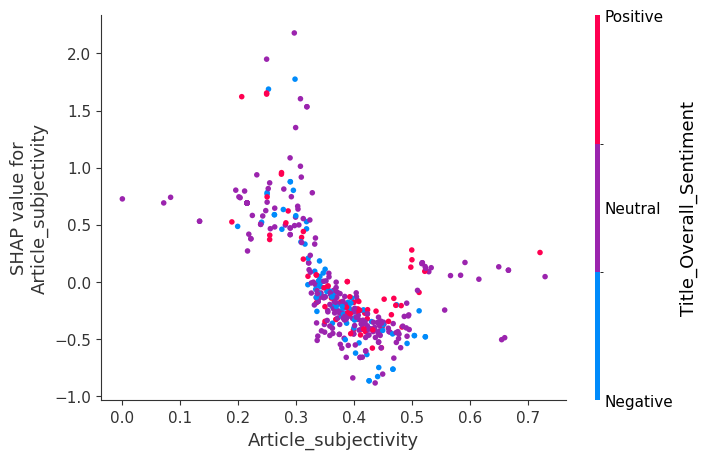

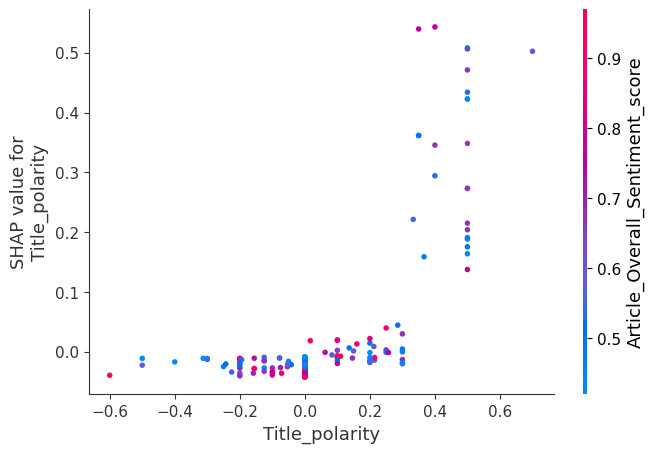

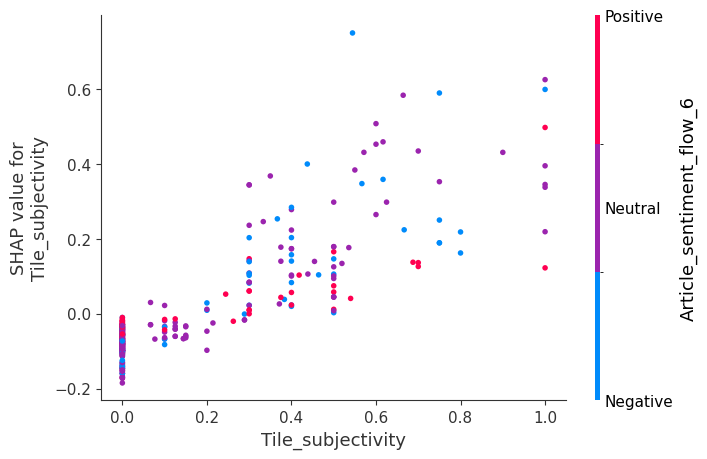

In [141]:
for name in lgbm_data.columns:
    shap.dependence_plot(name, shap_values_km[1], lgbm_data)

The Clusters are influenced by 
 - Over all sentiment of the Article (If an article's sentiment is very negative or positive or netural that affects the clusters which makes total sense)
 - Over all Emotion of the Article
 - What sentiment the article exibits when the article starts
 - How much personal opinions are shared in teh article
 - Polarity of teh article
 - What sentiment the Title represents

In [142]:
df_raw['Clusters'] =  kmeans_labels
df_temp = df_raw.groupby(['Clusters','Article_Overall_Sentiment', 'Article_Overall_Emotion']).agg({'Clusters':'count'})  \
                                                            .rename(columns={'Clusters':'Cluster_Count'}).reset_index()  \
                                                            .sort_values(by = ['Cluster_Count'],ascending=False).head(5) 


In [143]:
df_temp

Clusters Article_Overall_Sentiment Article_Overall_Emotion  Cluster_Count
1          0                   Neutral                   anger            173
3          0                   Neutral                     joy             57
15         1                  Positive                     joy             43
5          1                  Negative                   anger             41
11         1                   Neutral                     joy             23

In [144]:

print('''The clusters are definbed by
      - 1 - Neutral anger - Left
      - 0 - Neutral joy - Right/Cen
      - 2 - Positive - Right
      ''')
df_temp

The clusters are definbed by
      - 1 - Neutral anger - Left
      - 0 - Neutral joy - Right/Cen
      - 2 - Positive - Right
      


Clusters Article_Overall_Sentiment Article_Overall_Emotion  Cluster_Count
1          0                   Neutral                   anger            173
3          0                   Neutral                     joy             57
15         1                  Positive                     joy             43
5          1                  Negative                   anger             41
11         1                   Neutral                     joy             23

In [146]:
df_temp = df_raw.groupby(['Meta_Publisher','Clusters']).agg({'Clusters':'count'}).rename(columns={'Clusters':'Cluster_Count'}).reset_index()
df_temp = df_temp.pivot_table(index='Meta_Publisher',columns='Clusters',values='Cluster_Count').fillna(0.0).reset_index()
df_temp['Dominant_Cluster'] = df_temp[[0,1]].idxmax(axis=1) #2

In [147]:
df_temp.sort_values('Dominant_Cluster')

Clusters           Meta_Publisher     0     1  Dominant_Cluster
23                   Zee Business   1.0   0.0                 0
17        The Hindu Business Line   6.0   5.0                 0
16                      The Hindu  12.0   3.0                 0
15             The Economic Times  30.0  28.0                 0
14                Telegraph India   5.0   2.0                 0
13                Telangana Today   1.0   0.0                 0
12                    SwarajyaMag   9.0   5.0                 0
22                  Tribune India   8.0   0.0                 0
10                       Republic  10.0   1.0                 0
9                   Outlook India   2.0   0.0                 0
8                         OpIndia   9.0   8.0                 0
7                      Onmanorama   3.0   0.0                 0
20                      Times Now   1.0   0.0                 0
5                     India Today   4.0   1.0                 0
4                 Hindustan Times   9.0   0.0                 0
3                 Financial Times  12.0   1.0                 0
2                   Daily Pioneer   2.0   1.0                 0
21                 Times of India  19.0   6.0                 0
18                       The Wire  25.0   8.0                 0
19                       ThePrint   5.0   1.0                 0
0                  Business Today  22.0  33.0                 1
1                    CNBCTV18.com   2.0   3.0                 1
6                            Mint  32.0  34.0                 1
11                         Scroll  10.0  17.0                 1

In [154]:
df_temp['Bias Meter 0'] = round(df_temp[0]/(df_temp[0] + df_temp[1]),2)
df_temp['Bias Meter 1'] = round(df_temp[1]/(df_temp[0] + df_temp[1]),2)
df_temp['Bias Meter'] = abs(df_temp['Bias Meter 0'] - df_temp['Bias Meter 1']) *100  


In [159]:
df_temp['Bias Meter Z Score'] = (df_temp[	'Bias Meter'] - df_temp['Bias Meter'].mean())/df_temp['Bias Meter'].std()

In [160]:
df_temp.sort_values('Bias Meter Z Score')

Clusters           Meta_Publisher     0     1  Dominant_Cluster  Bias Meter  \
15             The Economic Times  30.0  28.0                 0         4.0   
6                            Mint  32.0  34.0                 1         4.0   
8                         OpIndia   9.0   8.0                 0         6.0   
17        The Hindu Business Line   6.0   5.0                 0        10.0   
0                  Business Today  22.0  33.0                 1        20.0   
1                    CNBCTV18.com   2.0   3.0                 1        20.0   
11                         Scroll  10.0  17.0                 1        26.0   
12                    SwarajyaMag   9.0   5.0                 0        28.0   
2                   Daily Pioneer   2.0   1.0                 0        34.0   
14                Telegraph India   5.0   2.0                 0        42.0   
21                 Times of India  19.0   6.0                 0        52.0   
18                       The Wire  25.0   8.0                 0        52.0   
5                     India Today   4.0   1.0                 0        60.0   
16                      The Hindu  12.0   3.0                 0        60.0   
19                       ThePrint   5.0   1.0                 0        66.0   
10                       Republic  10.0   1.0                 0        82.0   
3                 Financial Times  12.0   1.0                 0        84.0   
20                      Times Now   1.0   0.0                 0       100.0   
7                      Onmanorama   3.0   0.0                 0       100.0   
22                  Tribune India   8.0   0.0                 0       100.0   
9                   Outlook India   2.0   0.0                 0       100.0   
4                 Hindustan Times   9.0   0.0                 0       100.0   
13                Telangana Today   1.0   0.0                 0       100.0   
23                   Zee Business   1.0   0.0                 0       100.0   

Clusters  Bias Meter 0  Bias Meter 1  Bias Meter Z Score  
15                0.52          0.48           -1.443026  
6                 0.48          0.52           -1.443026  
8                 0.53          0.47           -1.387791  
17                0.55          0.45           -1.277320  
0                 0.40          0.60           -1.001142  
1                 0.40          0.60           -1.001142  
11                0.37          0.63           -0.835436  
12                0.64          0.36           -0.780201  
2                 0.67          0.33           -0.614494  
14                0.71          0.29           -0.393553  
21                0.76          0.24           -0.117375  
18                0.76          0.24           -0.117375  
5                 0.80          0.20            0.103566  
16                0.80          0.20            0.103566  
19                0.83          0.17            0.269273  
10                0.91          0.09            0.711156  
3                 0.92          0.08            0.766392  
20                1.00          0.00            1.208275  
7                 1.00          0.00            1.208275  
22                1.00          0.00            1.208275  
9                 1.00          0.00            1.208275  
4                 1.00          0.00            1.208275  
13                1.00          0.00            1.208275  
23                1.00          0.00            1.208275

In [ ]:
print('''We can bucket the Media Publishers into three buckets
      - Negative but neutrally negative
      - Negative with anger emotion
      - Postive with mild joy emotion

      - Negative but neutrally negative : Zee BusinessCNBCTV18.com,CNBCTV18.com,Times of India,Financial Times, Mint, The Hindu Business Line, Outlook india,
                                            The Economic Times
    
      - Negative with anger emotion : The Print, The Wire, The Hindu, Telegraph India, Business Today
      - Negative with mild joy and positive emotion : Swarajya, Tribune India, Republic,OpIndia, Onmanorama, India Today, Hindustan Times, Daily Pioneer  
      - Scroll is extremely Positive


      ''')
df_temp.sort_values('Dominant_Cluster')

We can bucket the Media Publishers into three buckets
      - Negative but neutrally negative
      - Negative with anger emotion
      - Postive with mild joy emotion

      - Negative but neutrally negative : Zee BusinessCNBCTV18.com,CNBCTV18.com,Times of India,Financial Times, Mint, The Hindu Business Line, Outlook india,
                                            The Economic Times
    
      - Negative with anger emotion : The Print, The Wire, The Hindu, Telegraph India, Business Today
      - Negative with mild joy and positive emotion : Swarajya, Tribune India, Republic,OpIndia, Onmanorama, India Today, Hindustan Times, Daily Pioneer  
      - Scroll is extremely Positive


      


Clusters           Meta_Publisher     0     1     2  Dominant_Cluster
23                   Zee Business   2.0   0.0   0.0                 0
21                 Times of India  14.0   8.0  12.0                 0
3                 Financial Times  19.0   2.0   0.0                 0
9                   Outlook India   2.0   0.0   0.0                 0
17        The Hindu Business Line   4.0   5.0   4.0                 1
15             The Economic Times  24.0  29.0  25.0                 1
0                  Business Today   8.0  35.0  27.0                 1
11                         Scroll   0.0  15.0  12.0                 1
1                    CNBCTV18.com   1.0   2.0   2.0                 1
20                      Times Now   0.0   0.0   1.0                 2
19                       ThePrint   0.0   0.0   9.0                 2
18                       The Wire   1.0   6.0  27.0                 2
2                   Daily Pioneer   0.0   0.0   3.0                 2
16                      The Hindu   0.0   2.0  19.0                 2
6                            Mint  18.0  28.0  38.0                 2
7                      Onmanorama   0.0   0.0   4.0                 2
13                Telangana Today   0.0   0.0   1.0                 2
12                    SwarajyaMag   4.0   4.0   6.0                 2
22                  Tribune India   2.0   0.0   7.0                 2
10                       Republic   0.0   1.0  10.0                 2
5                     India Today   0.0   1.0   4.0                 2
8                         OpIndia   1.0   2.0  14.0                 2
14                Telegraph India   0.0   2.0   7.0                 2
4                 Hindustan Times   1.0   0.0   8.0                 2

### Analysis & Insights Gathering

['Zee Business', 'CNBCTV18.com', 'Times of India', 'Financial Times', 'Mint', 'The Hindu Business Line', 'Outlook India', 'The Economic Times']


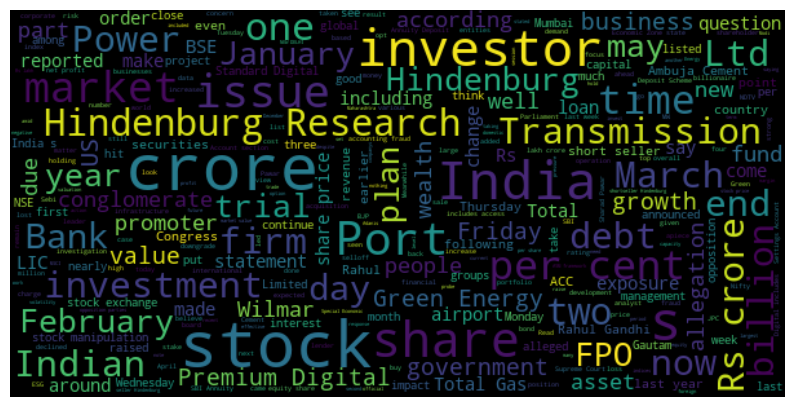

In [ ]:
center_media_publisher = ['Zee Business',
'CNBCTV18.com',
'Times of India',
'Financial Times',
'Mint',
'The Hindu Business Line',
'Outlook India',
'The Economic Times'
]

stopwords = set(STOPWORDS)
stopwords.update(["Adani","Group","group","kaminski","report","said", "will", "companies", "company", "Hidenburg", "report", "Enterprises"])
center_wing = df_raw[df_raw['Meta_Publisher'].isin(center_media_publisher)]['Article'].str.cat(sep=' ')

# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(stopwords=stopwords,
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(center_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print(center_media_publisher)
plt.show()

Center Media Houses Focus on more factual stuff.
We do not see any biased words from the word cloud.

['SwarajyaMag', 'Tribune India', 'Republic', 'OpIndia', 'Onmanorama', 'India Today', 'Hindustan Times', 'Daily Pioneer', 'Telangana Today', 'Scroll']


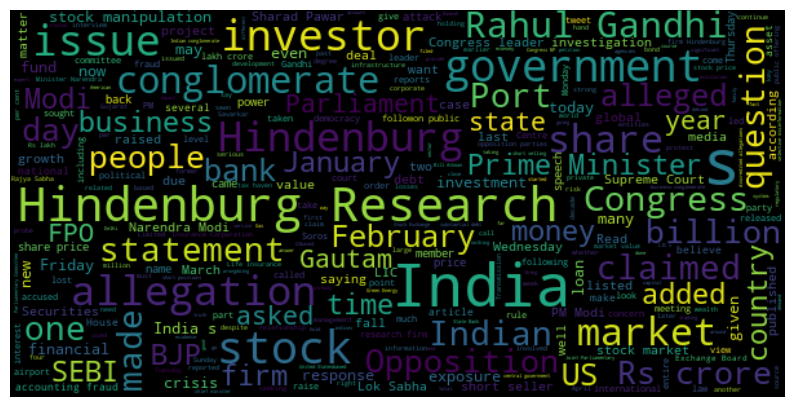

In [ ]:
right_media_publisher = ['SwarajyaMag',
'Tribune India',
'Republic',	
'OpIndia',	
'Onmanorama',
'India Today',
'Hindustan Times',
'Daily Pioneer',
'Telangana Today',
'Scroll'
]

right_wing = df_raw[df_raw['Meta_Publisher'].isin(right_media_publisher)]['Article'].str.cat(sep=' ')
# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(stopwords=stopwords,
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(right_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print(right_media_publisher)
plt.show()

Right Media Houses Focus on more opposition party congress.
We can see 
 - Rajul Gandhi
 - Opposition
 - Parliment
 - Congress
 - conglomerate
 - Stock Manipulation

['Times Now', 'ThePrint', 'The Wire', 'The Hindu', 'Telegraph India']


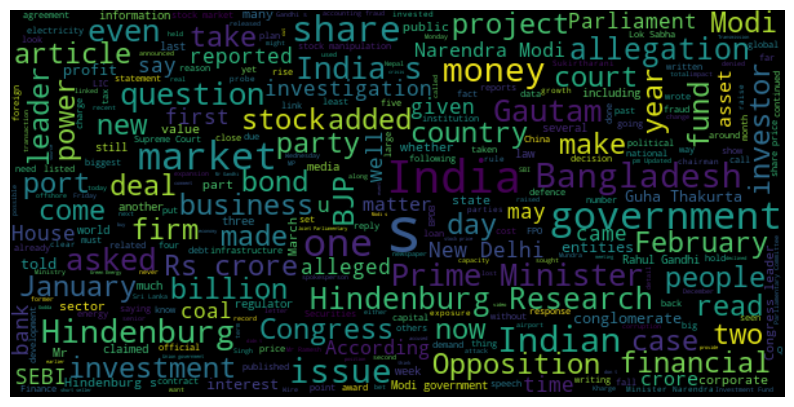

In [ ]:
left_media_publisher = ['Times Now',
'ThePrint',
'The Wire',
'The Hindu',
'Telegraph India']

left_wing = df_raw[df_raw['Meta_Publisher'].isin(left_media_publisher)]['Article'].str.cat(sep=' ')
# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(stopwords=stopwords,
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(left_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print(left_media_publisher)
plt.show()

Left Media Houses Focus on more BJP party.
We can see 
 - BJP
 - allegation
 - Coal
 - Modi
 - India
 - Prime Minister

##### Dispersion Plot

In [ ]:
left_wing_token = word_tokenize(left_wing)
right_wing_token = word_tokenize(right_wing)
center_wing_token = word_tokenize(center_wing)

Left Wing
Right Wing


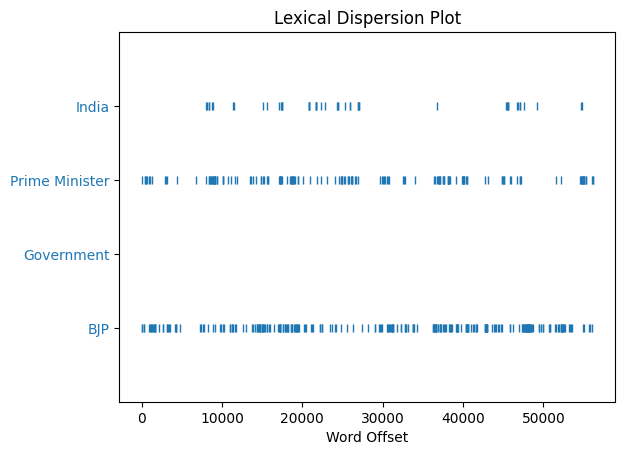

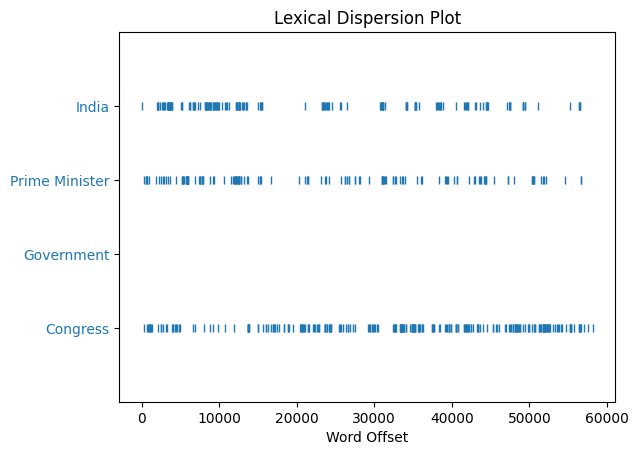

In [ ]:
print('Left Wing')
Text(left_wing_token).dispersion_plot([ 'BJP','Government',
                                 'Prime Minister', 'India'] )
print('Right Wing')
Text(right_wing_token).dispersion_plot([ 'Congress' ,'Government',
                                 'Prime Minister', 'India'] )
# print('Center Wing')
# Text(center_wing_token).dispersion_plot([ 'BJP','Congress','Government',
#                                  'Prime Minister', 'India'] )

##### Word Context

In [ ]:
print(Text(word_tokenize(left_wing)).concordance('modi')) # Displaying whereever India comes


Displaying 25 of 140 matches:
ss Credit Sights had warned long ago Modi Government did not listen Our banks 
ressure from Prime Minister Narendra Modi to okay the Adani proposal Mr Rajapa
it to Delhi last year when he and Mr Modi had issued a joint vision statement 
lso read How Gautam Adani is helping Modi govt with India s foreign policy cha
Almost two weeks into the crisis the Modi government hasn t said a word about 
ould be good capitalism Also Read If Modi wants a real legacy he must undo Ind
ess on Monday asked why the Narendra Modi government can not agree to a joint 
 speech and comments made against Mr Modi Stating that the stock market crashe
eries of questions to Prime Minister Modi under the Hum Adani ke Hain Kaun ser
ken on Friday asked why the Narendra Modi government was scared of forming a J
 The Congress party wants to ask the Modi government why it is scared of formi
he reveal if Prime Minister Narendra Modi was himself steering a power purchas
am Adani and Prime Min

In [ ]:
print(Text(word_tokenize(right_wing)).concordance('modi')) # Displaying whereever India comes

Displaying 25 of 145 matches:
ashed out at Prime Minister Narendra Modi yet again accusing the BJP leader of
le use the family name of the father Modi may have all the agencies in his han
s hand But I do not fear him One day Modi will have to face the truth he lashe
 growth of Gautham Adani is the only Modi Magic that happened in the last eigh
st eight years He showed pictures of Modi and Adani travelling together during
taken by the prime minister Wherever Modi goes he takes Adani along with him o
Security Conference on Thursday said Modi would have to answer questions from 
ween the war and Indias interests is Modi BJP leader and Union minister Smriti
urkey disaster and failures in China Modi and business tycoon Adani are close 
tock collapsed like a house of cards Modi is silent on the subject but he will
 a democracy but its leader Narendra Modi is no democrat he claimed Modi he sa
endra Modi is no democrat he claimed Modi he said maintains close relations wi
rkey Erdogan has much 

In [ ]:
print(Text(word_tokenize(center_wing)).concordance('modi')) # Displaying whereever India comes


Displaying 25 of 82 matches:
use of cards Prime Minister Narendra Modi must address the matter the AAP MP u
AP MP said that he had written to PM Modi requesting that the passport of Gaut
 be confiscated I have written to PM Modi CBI and ED to confiscate Adanis pass
ework and sparked questions about PM Modi s ties with Adani Modi is silent on 
ions about PM Modi s ties with Adani Modi is silent on the subject but he will
rence This will significantly weaken Modi s stranglehold on India s federal go
crisis has also put the spotlight on Modi s relationship with Adani India s op
ycoon s meteoric growth that mirrors Modi s political journey to the top elect
al journey to the top elected office Modi has not directly addressed the issue
oximity with Prime Minister Narendra Modi The Adani Group has dismissed all al
die down Investment will not be hurt Modi is a sensible and dynamic person and
p because of Prime Minister Narendra Modi telling them to do so was rubbishWha
rt to attack the govern

#### BERTTOPIC- Clustering

In [ ]:
!pip install bertopic[flair]
!pip install bertopic[gensim]
!pip install bertopic[spacy]
!pip install bertopic[use]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip uninstall protobuf
!pip uninstall google
!pip install google
!pip install protobuf
!pip install google-cloud

Found existing installation: protobuf 4.22.3
Uninstalling protobuf-4.22.3:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/google/_upb/_message.abi3.so
    /usr/local/lib/python3.9/dist-packages/google/protobuf/*
    /usr/local/lib/python3.9/dist-packages/protobuf-4.22.3.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled protobuf-4.22.3
Found existing installation: google 2.0.3
Uninstalling google-2.0.3:
  Would remove:
    /usr/local/bin/google
    /usr/local/lib/python3.9/dist-packages/google-2.0.3.dist-info/*
    /usr/local/lib/python3.9/dist-packages/googlesearch/*
Proceed (Y/n)? Y
  Successfully uninstalled google-2.0.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-4.22.3-cp37-abi3-manylinux2014_x86_64.whl (302 kB

In [ ]:
df_raw = pd.read_csv('/content/processed_data.csv')

In [ ]:
import numpy as np
import pandas as pd 
import glob
import json
import seaborn as sns
from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('ggplot')


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()


from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from operator import itemgetter
import gensim
from gensim.utils import simple_preprocess
import numpy as np
from collections import Counter
import pprint 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

In [ ]:
# Get the top 20 most common words among all the articles
temp_text = df_raw['Article']

# split single string in format of "['word1', 'word2', 'word3', ...]" to list of string ['word1' , 'word2', 'word3', ...]
try:
    temp_text = temp_text.apply(lambda x: x[1:-1].split(', '))
    temp_text = temp_text.apply(lambda x: [item[1:-1] for item in x])
except:
    print("already in req. format")
p_text = [item for sublist in temp_text for item in sublist]

df_raw['processed_text'] = temp_text

In [ ]:
# remove sopwords and all non-alphabetic characters from processed_text column and save it in processed_text column

stopwords = ['Adani','international','report','share','stocks','doi','org','no','https','january','february', 'march','april','may','june','july','august', 'september','october','november','december','`','\'','covid','sars','cov']

stopwords = set(stopwords)
# print frequency of cc in processed_text column
print("Frequency of cc in processed_text column: ", df_raw['processed_text'].apply(lambda x: x.count('cc')).sum())

# Remove stopwords from processed_text column
df_raw['processed_text'] = df_raw['processed_text'].apply(lambda x: [item for item in x if item not in stopwords])

# print frequency of cc in processed_text column
print("Frequency of cc in processed_text column: ", df_raw['processed_text'].apply(lambda x: x.count('cc')).sum())

# print frequency of sars 
print("Frequency of sars in processed_text column: ", df_raw['processed_text'].apply(lambda x: x.count('sars')).sum())

Frequency of cc in processed_text column:  0
Frequency of cc in processed_text column:  0
Frequency of sars in processed_text column:  0


In [ ]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

349

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_raw.columns

Index(['Meta_Publisher', 'Meta_datetime', 'Meta_title', 'Meta_link',
       'Meta_desc', 'Published_Date', 'Title', 'Article', 'Summary', 'Authors',
       'Keywords', 'index', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flo

In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=5, n_components=15, metric='cosine', low_memory=False)
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', prediction_data=True)

text_ = df_raw['Article']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english",ngram_range=(1, 2))

topic_model = BERTopic(umap_model=umap_model,
                       verbose=True,
                       vectorizer_model=vectorizer_model,
                       min_topic_size = 5, 
                       nr_topics=5,
                       hdbscan_model=hdbscan_model) # min_topic_size= 100 , nr_topics= 50 ,
topics, probabilities = topic_model.fit_transform(text_)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2023-04-22 12:41:53,733 - BERTopic - Transformed documents to Embeddings
2023-04-22 12:41:57,520 - BERTopic - Reduced dimensionality
2023-04-22 12:41:57,560 - BERTopic - Clustered reduced embeddings
2023-04-22 12:42:00,564 - BERTopic - Reduced number of topics from 34 to 5


In [ ]:
freq = topic_model.get_topic_info()
freq.head(20)

Topic  Count                             Name
0     -1    125  -1_adani_group_adani group_said
1      0    312   0_adani_group_said_adani group
2      1     27   1_digital_trial_premium_access
3      2     10     2_sbi_deposit_scheme_annuity
4      3      9      3_airport_airports_bid_said

In [ ]:
topic_nr = freq.iloc[0]['Topic']
topic_model.get_topic(topic_nr)

[('adani', 0.0421765554273925),
 ('group', 0.028862116501694342),
 ('adani group', 0.02100579119060296),
 ('said', 0.019879313270039528),
 ('india', 0.013259356702121528),
 ('report', 0.013106654527455243),
 ('hindenburg', 0.012444337436438304),
 ('company', 0.011709439319624483),
 ('companies', 0.00995233487630526),
 ('crore', 0.009771228851948586)]

In [ ]:
fig = topic_model.visualize_topics()

In [ ]:
fig

In [ ]:
topic_model.visualize_documents(text_)

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model = BERTopic(verbose=True,vectorizer_model=vectorizer_model, min_topic_size = 2, 
                       nr_topics=10)
topics, probs = topic_model.fit_transform(text_)
hierarchical_topics = topic_model.hierarchical_topics(text_)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2023-04-22 12:49:38,268 - BERTopic - Transformed documents to Embeddings
2023-04-22 12:49:42,083 - BERTopic - Reduced dimensionality
2023-04-22 12:49:42,131 - BERTopic - Clustered reduced embeddings
2023-04-22 12:49:50,904 - BERTopic - Reduced number of topics from 75 to 10
100%|██████████| 8/8 [00:00<00:00, 70.16it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

### Final Thoughts & Future Work